# A. Markovich, N. Puchkin
# Numerical experiments on WISDM human activity data set, described in the paper
# "Score-based change point detection via tracking the best of infinitely many experts"

In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import normal as randn, multivariate_normal as randmn
import pandas as pd
from algorithms.score_based import *
from algorithms.kliep import compute_test_stat_kliep
from algorithms.m_statistic import compute_test_stat_mmd
from algorithms.fast_contrastive_change_point import compute_test_stat_ftal
%load_ext autoreload
%autoreload 2

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### Auxiliary function and preprocessing

In [2]:
# Auxiliary function to compute delays
def compute_delays(true_cp, detected_cp):
    
    false_alarms = 0
    not_detected = 0
    delays = []
    
    cp_all = np.append(true_cp, detected_cp)
    pattern = np.append(np.zeros(len(true_cp)), np.ones(len(detected_cp)))
    
    ind_sorted = np.argsort(cp_all)
    cp_sorted = cp_all[ind_sorted]
    pattern_sorted = pattern[ind_sorted]
    
    if pattern_sorted[0] == 1:
        false_alarms += 1
        
    for i in range(1, len(pattern_sorted)):

        # Correctly detected change point
        if (pattern_sorted[i] == 1) and (pattern_sorted[i - 1] == 0):
            delays += [cp_sorted[i] - cp_sorted[i - 1]]
            
        # False alarm
        if (pattern_sorted[i] == 1) and (pattern_sorted[i - 1] == 1) and (i < len(pattern_sorted) - 1):
            false_alarms += 1
            
        # Non-detected change point
        if (pattern_sorted[i] == 0) and (pattern_sorted[i - 1] == 0):
            delays += [cp_sorted[i] - cp_sorted[i - 1]]
            not_detected += 1
    
    
    #print(delays)
    delays = np.array(delays)
    delays_mean = np.mean(delays)
    delays_std = np.std(delays)
    
    return false_alarms, delays_mean, delays_std, not_detected

In [3]:
# Read the data
df = pd.read_csv('data/WISDM/sample_0.csv')

# Feature vectors
X = np.array(df[['X1', 'X2', 'X3']])
print(X.shape)

# Labels
labels = np.array(df['Label'])
change_points = np.where(labels)[0]

(64868, 3)


In [4]:
# Data preprocessing
# Reduce the data, averaging over 20 values

bandwidth = 20
N = X.shape[0] // bandwidth

data = np.empty((0, 3))
new_labels = np.empty(0)

for t in range(N):
        
    data = np.append(data, np.mean(X[bandwidth * t : bandwidth * (t + 1)], axis=0).reshape(1, -1), axis=0)
    new_labels = np.append(new_labels, np.sum(labels[bandwidth * t : bandwidth * (t + 1)]))
    
change_points = np.where(new_labels)[0]
print(change_points)


[ 180  360  540  720  900 1080 1260 1440 1620 1801 1981 2161 2341 2521
 2702 2882 3063]


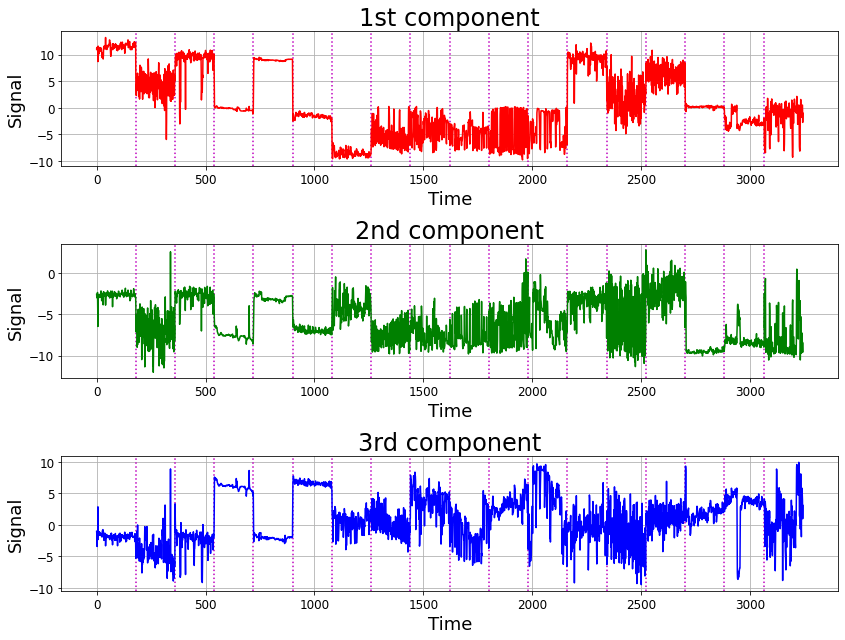

In [5]:
plt.figure(figsize=(12, 9))

plt.subplot(3, 1, 1)

for i in range(len(change_points)):
    plt.axvline(change_points[i], c='m', ls=':')

plt.plot(np.arange(data.shape[0]), data[:, 0], c='r')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(label='1st component', fontsize=24)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Signal', fontsize=18)
plt.grid()

plt.subplot(3, 1, 2)

for i in range(len(change_points)):
    plt.axvline(change_points[i], c='m', ls=':')

plt.plot(np.arange(data.shape[0]), data[:, 1], c='g')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(label='2nd component', fontsize=24)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Signal', fontsize=18)
plt.grid()

plt.subplot(3, 1, 3)

for i in range(len(change_points)):
    plt.axvline(change_points[i], c='m', ls=':')

plt.plot(np.arange(data.shape[0]), data[:, 2], c='b')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(label='3rd component', fontsize=24)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Signal', fontsize=18)
plt.grid()

plt.tight_layout()


In [6]:
data /= data.max(axis=0)

In [7]:
# Split the data into the stationary part, validation part, and test part

# Stationary part: three parts of the time series without the change points.
# Used to tune the threshold
#
data_stationary = [data[:180], data[181:360], data[361:540], data[541:720]]

# Validation part: a part with several change points to tune the hyperparameters
val_start = 0
val_end = 1670
data_val = data[val_start:val_end]

# Test part: check the performance of the procedures
test_start = 1670
test_end = 3060
data_test = data[test_start:test_end]


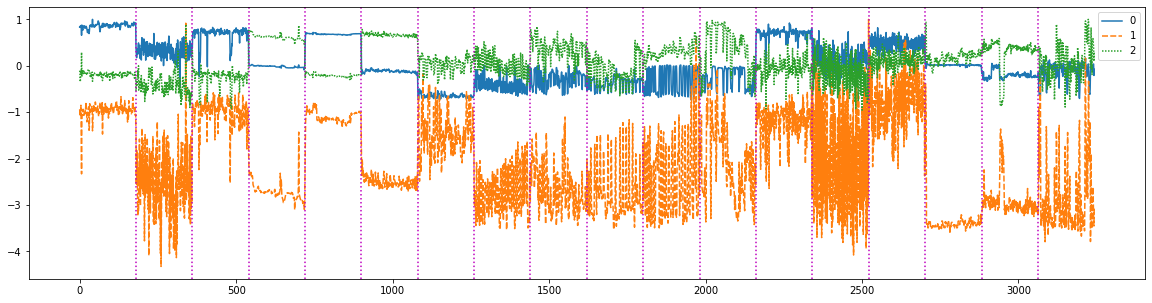

In [8]:
plt.figure(figsize=(20, 5))
sns.lineplot(data)
for i in range(len(change_points)):
    plt.axvline(change_points[i], c='m', ls=':')

### Score-based with quadratic basis $\Psi$

In [16]:

# The lists of hyperparameters for training
eta_list = [0.1, 0.3, 0.5]
lambda_list = [1, 2, 5]
alpha_list = [1e-5, 1e-4, 1e-3]

dim=3
# Change points on the validation set
change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
for eta in eta_list:
    for l in lambda_list:
        for a in alpha_list:
            
            #----------------------------------------------------
            # Step 1: tuning the threshold on the stationary part
            #----------------------------------------------------
            
            S_stationary = np.empty(0)
            for ds in data_stationary:
                
                X = ds.copy()
                n = X.shape[0]
                model = ChangePointDetector(d_dim=dim*2, x_dim=dim, lambda_=l, alpha=a, basis=PolyBasis(2, dim))
                new_S_q, _ = model.run(X.reshape((n, dim, 1)), eta)  
                S_stationary = np.append(S_stationary, new_S_q)
                
            # Set the threshold as the maximal value on the stationary part
            z = 0.3 * np.max(S_stationary)
            print('threshold =', z)
            
            #----------------------------------------------------
            # Step 2: detect changes on the validation part
            #----------------------------------------------------
            
            # Initialization of the test statistic
            S_q = np.empty(0)

            # Initialization of the list of detected change points
            change_points_q = []

            # Initialization of the delays array and
            # the false alarms counter
            delays_q = np.empty(0)
            current_change_point_ind = 0
            false_alarms_q = 0

            # Initialization
            st_q = 0
            new_st_q = 0
            
            while new_st_q >= 0:
                # Run the procedure until the moment
                # it reports a change point occurrence

                X = data_val[st_q + 1:].copy()
                n = X.shape[0]
                model = ChangePointDetector(d_dim=dim*2, x_dim=dim, lambda_=l, alpha=a, basis=PolyBasis(2, dim), threshold=z)
                new_S_q, new_st_q = model.run(X.reshape((n, dim, 1)), eta)  

                S_q = np.append(S_q, new_S_q)

                if new_st_q >= 0:
                    st_q += new_st_q
                    change_points_q += [int(st_q)]
                else:
                    change_points_q += [int(data_val.shape[0] - 1)]

            print('Detected change points:', change_points_q)
            
            false_alarms_q, mean_delay_q, std_delay_q, not_detected_q\
            = compute_delays(change_points_val, change_points_q)

            print(f'q, eta={eta}, lambda =', l, '; alpha = ', a,  '. Number of false alarms:', false_alarms_q,\
                '; average delay:', np.round(mean_delay_q, 4), '±', np.round(std_delay_q, 4),\
                '; non-detected:', not_detected_q)




Validation change points: [ 180  360  540  720  900 1080 1260 1440 1620]
threshold = 32.55633933298177
Detected change points: [182, 378, 463, 544, 722, 902, 1083, 1268, 1444, 1669]
q, eta=0.1, lambda = 1 ; alpha =  1e-05 . Number of false alarms: 1 ; average delay: 10.2222 ± 14.5356 ; non-detected: 0
threshold = 42.657110255361566
Detected change points: [182, 376, 470, 544, 722, 902, 1083, 1268, 1444, 1669]
q, eta=0.1, lambda = 1 ; alpha =  0.0001 . Number of false alarms: 1 ; average delay: 10.0 ± 14.4299 ; non-detected: 0
threshold = 47.59127537691206
Detected change points: [182, 379, 455, 543, 722, 902, 1083, 1267, 1443, 1669]
q, eta=0.1, lambda = 1 ; alpha =  0.001 . Number of false alarms: 1 ; average delay: 10.0 ± 14.7196 ; non-detected: 0
threshold = 0.13055181430611354
Detected change points: [183, 532, 599, 723, 902, 1083, 1443, 1669]
q, eta=0.1, lambda = 2 ; alpha =  1e-05 . Number of false alarms: 0 ; average delay: 52.6667 ± 69.0748 ; non-detected: 1
threshold = 1.176995

In [49]:
# The lists of hyperparameters for training
eta_list = [0.05, 0.1, 0.15, 0.45, 0.5, 0.55]
lambda_list = [0.95, 1, 1.1, 1.2, 4.5, 5, 5.5]
alpha_list = [1e-5, 1e-4, 1e-3]

dim=3
# Change points on the validation set
change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
for eta in eta_list:
    for l in lambda_list:
        for a in alpha_list:
    
            #----------------------------------------------------
            # Step 1: tuning the threshold on the stationary part
            #----------------------------------------------------
            S_stationary = np.empty(0)
            for ds in data_stationary:
                
                X = ds.copy()
                n = X.shape[0]
                model = ChangePointDetector(d_dim=dim*2, x_dim=dim, lambda_=l, alpha=a, basis=PolyBasis(2, dim))
                new_S_q, _ = model.run(X.reshape((n, dim, 1)), eta)  
                S_stationary = np.append(S_stationary, new_S_q)
                
            # Set the threshold as the maximal value on the stationary part
            z = 0.3* np.max(S_stationary)
            print('threshold =', z)
            
            #----------------------------------------------------
            # Step 2: detect changes on the validation part
            #----------------------------------------------------
            
            # Initialization of the test statistic
            S_q = np.empty(0)

            # Initialization of the list of detected change points
            change_points_q = []

            # Initialization of the delays array and
            # the false alarms counter
            delays_q = np.empty(0)
            current_change_point_ind = 0
            false_alarms_q = 0

            # Initialization
            st_q = 0
            new_st_q = 0
            
            while new_st_q >= 0:
                # Run the procedure until the moment
                # it reports a change point occurrence

                X = data_val[st_q + 1:].copy()
                n = X.shape[0]
                model = ChangePointDetector(d_dim=dim*2, x_dim=dim, lambda_=l, alpha=a, basis=PolyBasis(2, dim), threshold=z)
                new_S_q, new_st_q = model.run(X.reshape((n, dim, 1)), eta)  

                S_q = np.append(S_q, new_S_q)

                if new_st_q >= 0:
                    st_q += new_st_q
                    change_points_q += [int(st_q)]
                else:
                    change_points_q += [int(data_val.shape[0] - 1)]

            print('Detected change points:', change_points_q)
            
            false_alarms_q, mean_delay_q, std_delay_q, not_detected_q\
            = compute_delays(change_points_val, change_points_q)

            print(f'q, eta={eta}, lambda =', l, '; alpha = ', a,  '. Number of false alarms:', false_alarms_q,\
                '; average delay:', np.round(mean_delay_q, 4), '±', np.round(std_delay_q, 4),\
                '; non-detected:', not_detected_q)




Validation change points: [ 180  360  540  720  900 1080 1260 1440 1620]
threshold = 0.0
Detected change points: [185, 534, 612, 724, 902, 1083, 1443, 1669]
q, eta=0.05, lambda = 0.95 ; alpha =  1e-05 . Number of false alarms: 0 ; average delay: 54.6667 ± 69.4646 ; non-detected: 1
threshold = 0.05864126033936827
Detected change points: [184, 529, 594, 723, 902, 1083, 1443, 1669]
q, eta=0.05, lambda = 0.95 ; alpha =  0.0001 . Number of false alarms: 0 ; average delay: 51.8889 ± 68.3885 ; non-detected: 1
threshold = 0.7061828148409631
Detected change points: [184, 527, 590, 723, 902, 1083, 1443, 1669]
q, eta=0.05, lambda = 0.95 ; alpha =  0.001 . Number of false alarms: 0 ; average delay: 51.2222 ± 68.0062 ; non-detected: 1
threshold = 0.0
Detected change points: [186, 543, 723, 902, 1083, 1443, 1669]
q, eta=0.05, lambda = 1 ; alpha =  1e-05 . Number of false alarms: 0 ; average delay: 47.6667 ± 72.1326 ; non-detected: 2
threshold = 0.02227461508343822
Detected change points: [184, 542, 

In [14]:
# TRAIN

# Best hyperparameters for training
eta = 0.1
l = 0.95
a = 1e-5
# z = 36.19631395342578
# print('threshold =', z)

dim=3
# Change points on the validation set
change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
#----------------------------------------------------
# Step 1: tuning the threshold on the stationary part
#----------------------------------------------------
S_stationary = np.empty(0)
for ds in data_stationary:
    
    X = ds.copy()
    n = X.shape[0]
    model = ChangePointDetector(d_dim=dim*2, x_dim=dim, lambda_=l, alpha=a, basis=PolyBasis(2, dim))
    new_S_q, _ = model.run(X.reshape((n, dim, 1)), eta)  
    S_stationary = np.append(S_stationary, new_S_q)
    
# Set the threshold as the maximal value on the stationary part
z = 0.3* np.max(S_stationary)
print('threshold =', z)

#----------------------------------------------------
# Step 2: detect changes on the validation part
#----------------------------------------------------
    
# Initialization of the test statistic
S_q = np.empty(0)

# Initialization of the list of detected change points
change_points_q = []

# Initialization of the delays array and
# the false alarms counter
delays_q = np.empty(0)
current_change_point_ind = 0
false_alarms_q = 0

# Initialization
st_q = 0
new_st_q = 0

while new_st_q >= 0:
    # Run the procedure until the moment
    # it reports a change point occurrence

    X = data_val[st_q + 1:].copy()
    n = X.shape[0]
    model = ChangePointDetector(d_dim=dim*2, x_dim=dim, lambda_=l, alpha=a, basis=PolyBasis(2, dim), threshold=z)
    new_S_q, new_st_q = model.run(X.reshape((n, dim, 1)), eta)  

    S_q = np.append(S_q, new_S_q)

    if new_st_q >= 0:
        st_q += new_st_q
        change_points_q += [int(st_q)]
    else:
        change_points_q += [int(data_val.shape[0] - 1)]

print('Detected change points:', change_points_q)

false_alarms_q, mean_delay_q, std_delay_q, not_detected_q\
= compute_delays(change_points_val, change_points_q)

print(f'q, eta={eta}, lambda =', l, '; alpha = ', a,  '. Number of false alarms:', false_alarms_q,\
    '; average delay:', np.round(mean_delay_q, 4), '±', np.round(std_delay_q, 4),\
    '; non-detected:', not_detected_q)




Validation change points: [ 180  360  540  720  900 1080 1260 1440 1620]
threshold = 36.19631395342578
Detected change points: [182, 376, 470, 544, 722, 902, 1083, 1268, 1444, 1669]
q, eta=0.1, lambda = 0.95 ; alpha =  1e-05 . Number of false alarms: 1 ; average delay: 10.0 ± 14.4299 ; non-detected: 0


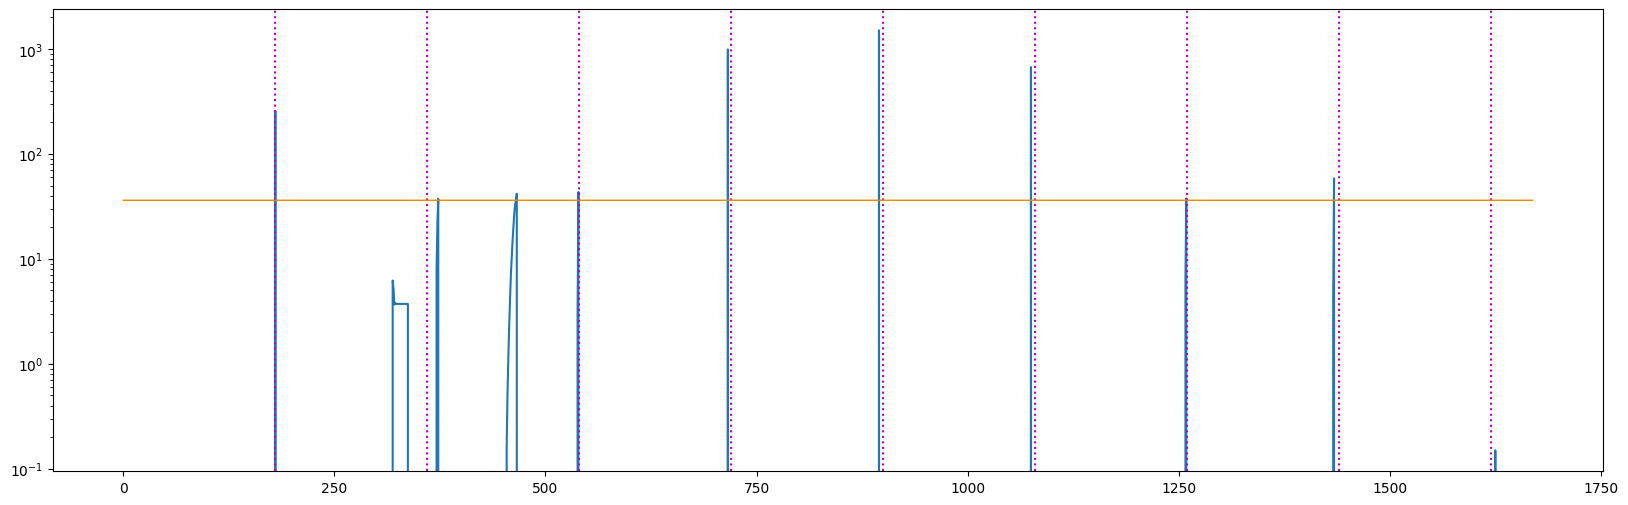

In [15]:
# Plot the test statistic on the train set
# Pink dotted lines correspond to true change points
plt.figure(figsize=(20, 6))
plt.plot(S_q)
plt.yscale('log')
z = 36.19631395342578
for i in range(len(change_points_val)):
    plt.axvline(change_points_val[i], c='m', ls=':')
plt.plot([z] * len(data_val), color="#e68a00", lw=1)

In [13]:
#----------------------------------------------------
# Step 3: detect changes on the test part
#----------------------------------------------------

# Best hyperparameters after training
eta = 0.1
lambda_ = 0.95
alpha = 1e-5
dim=3
z = 36.19631395342578


# Change points on the test set
change_points_test = change_points[change_points < test_end] - test_start
change_points_test = change_points_test[change_points_test > 0]
print('Test change points:', change_points_test)

# Initialization of the test statistic
S_q = np.empty(0)

# Initialization of the list of detected change points
change_points_q = []

# Initialization of the delays array and
# the false alarms counter
delays_q = np.empty(0)
current_change_point_ind = 0
false_alarms_q = 0


# Initialization
st_q = 0
new_st_q = 0
    
while new_st_q >= 0:
    # Run the procedure until the moment
    # it reports a change point occurrence

    X = data_test[st_q + 1:].copy()
    n = X.shape[0]
    model = ChangePointDetector(d_dim=dim*2, x_dim=dim, lambda_=lambda_, alpha=alpha, basis=PolyBasis(2, dim), threshold=z)
    new_S_q, new_st_q = model.run(X.reshape((n, dim, 1)), eta)  

    S_q = np.append(S_q, new_S_q)

    if new_st_q >= 0:
        st_q += new_st_q
        change_points_q += [int(st_q)]
    else:
        change_points_q += [int(data_test.shape[0] - 1)]

print('Detected change points:', change_points_q)
    
false_alarms_q, mean_delay_q, std_delay_q, not_detected_q\
= compute_delays(change_points_test, change_points_q)

print('Score-based quadratic basis. Number of false alarms:', false_alarms_q,\
      '; average delay:', np.round(mean_delay_q, 4), '±', np.round(std_delay_q, 4),\
      '; non-detected:', not_detected_q)

Test change points: [ 131  311  491  671  851 1032 1212]
Detected change points: [200, 320, 494, 676, 890, 1035, 1220, 1389]
Score-based quadratic basis. Number of false alarms: 0 ; average delay: 19.4286 ± 23.3841 ; non-detected: 0


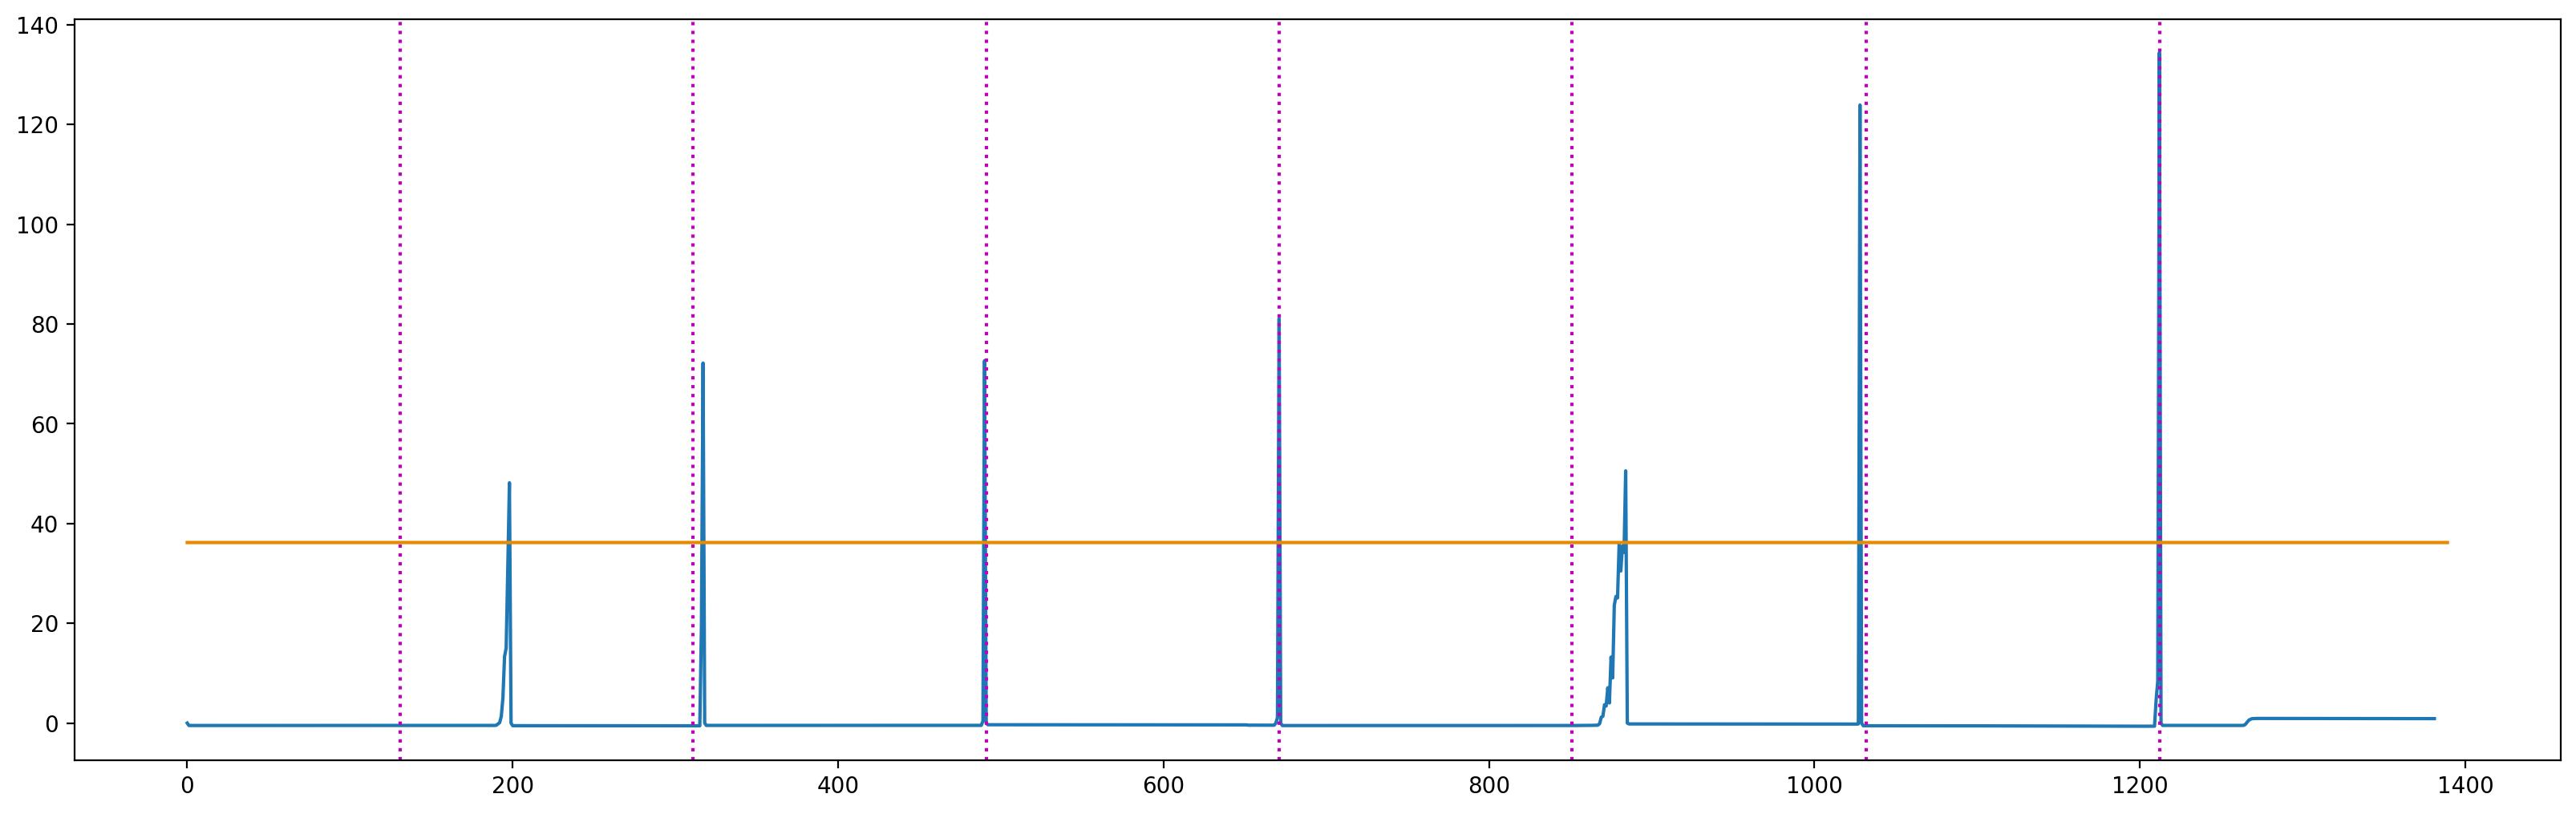

In [59]:
# Plot the test statistic on the test set
# Pink dotted lines correspond to true change points
plt.figure(figsize=(20, 6))
plt.plot(S_q)
for i in range(len(change_points_test)):
    plt.axvline(change_points_test[i], c='m', ls=':')
plt.plot([z] * len(data_test), color="#e68a00")
plt.show()

### FALCON

In [62]:
p = 1

# The list of hyperparameters
beta_list = [0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 2.5, 5]

# Change points on the validation set
change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
    
for b in beta_list:
    
    #----------------------------------------------------
    # Step 1: tuning the threshold on the stationary part
    #----------------------------------------------------
    
    S_stationary = np.empty(0)
    for ds in data_stationary:
        
        S, _ = compute_test_stat_ftal(ds, p, beta=b, design='multivariate')
        S_stationary = np.append(S_stationary, S)
        
    # Set the threshold as the maximal value on the stationary part
    z = np.max(S_stationary)
    print('beta =', b, ', threshold =', z)
    
    #----------------------------------------------------
    # Step 2: detect changes on the validation part
    #----------------------------------------------------
    
    # Initialization of the test statistic
    S_ftal = np.empty(0)

    # Initialization of the list of detected change points
    change_points_ftal = []

    # Initialization of the delays array and
    # the false alarms counter
    delays_ftal = np.empty(0)
    current_change_point_ind = 0
    false_alarms_ftal = 0

    # Initialization
    st_ftal = 0
    new_st_ftal = 0
    
    while new_st_ftal >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        new_S_ftal, new_st_ftal = compute_test_stat_ftal(data_val[st_ftal + 1:], p, beta=b,\
                                                       design='multivariate', threshold=z)

        S_ftal = np.append(S_ftal, new_S_ftal)

        if new_st_ftal >= 0:
            st_ftal += new_st_ftal
            change_points_ftal += [int(st_ftal)]
        else:
            change_points_ftal += [int(data_val.shape[0] - 1)]

    print('Detected change points:', change_points_ftal)
    
    false_alarms_ftal, mean_delay_ftal, std_delay_ftal, not_detected_ftal\
    = compute_delays(change_points_val, change_points_ftal)

    print('FTAL, beta =', b, '. Number of false alarms:', false_alarms_ftal,\
          '; average delay:', np.round(mean_delay_ftal, 4), '±', np.round(std_delay_ftal, 4),\
          '; non-detected:', not_detected_ftal)


Validation change points: [ 180  360  540  720  900 1080 1260 1440 1620]
beta = 0.005 , threshold = 9.441641896654122
Detected change points: [189, 370, 546, 727, 832, 910, 1091, 1266, 1399, 1456, 1630]
FTAL, beta = 0.005 . Number of false alarms: 2 ; average delay: 9.4444 ± 2.9102 ; non-detected: 0
beta = 0.01 , threshold = 9.728419312108867
Detected change points: [192, 372, 551, 723, 860, 914, 1093, 1269, 1381, 1454, 1639]
FTAL, beta = 0.01 . Number of false alarms: 2 ; average delay: 11.8889 ± 4.0673 ; non-detected: 0
beta = 0.02 , threshold = 9.605453694462062
Detected change points: [203, 375, 550, 719, 914, 1100, 1270, 1422, 1529, 1650]
FTAL, beta = 0.02 . Number of false alarms: 2 ; average delay: 43.4444 ± 53.5249 ; non-detected: 1
beta = 0.05 , threshold = 9.271603028432784
Detected change points: [221, 376, 552, 731, 911, 1096, 1270, 1461, 1656]
FTAL, beta = 0.05 . Number of false alarms: 0 ; average delay: 19.3333 ± 10.8115 ; non-detected: 0
beta = 0.1 , threshold = 9.31329

In [63]:
p = 1

# The list of hyperparameters
beta_list = [0.2, 0.4, 0.6, 1.4, 1.6, 2, 3, 3.2, 7.7, 8.5, 9, 9.3, 9.5, 11, 12, 13]

# Change points on the validation set
change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
    
for b in beta_list:
    
    #----------------------------------------------------
    # Step 1: tuning the threshold on the stationary part
    #----------------------------------------------------
    
    S_stationary = np.empty(0)
    for ds in data_stationary:
        
        S, _ = compute_test_stat_ftal(ds, p, beta=b, design='multivariate')
        S_stationary = np.append(S_stationary, S)
        
    # Set the threshold as the maximal value on the stationary part
    z = np.max(S_stationary)
    print('beta =', b, ', threshold =', z)
    
    #----------------------------------------------------
    # Step 2: detect changes on the validation part
    #----------------------------------------------------
    
    # Initialization of the test statistic
    S_ftal = np.empty(0)

    # Initialization of the list of detected change points
    change_points_ftal = []

    # Initialization of the delays array and
    # the false alarms counter
    delays_ftal = np.empty(0)
    current_change_point_ind = 0
    false_alarms_ftal = 0

    # Initialization
    st_ftal = 0
    new_st_ftal = 0
    
    while new_st_ftal >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        new_S_ftal, new_st_ftal = compute_test_stat_ftal(data_val[st_ftal + 1:], p, beta=b,\
                                                       design='multivariate', threshold=z)

        S_ftal = np.append(S_ftal, new_S_ftal)

        if new_st_ftal >= 0:
            st_ftal += new_st_ftal
            change_points_ftal += [int(st_ftal)]
        else:
            change_points_ftal += [int(data_val.shape[0] - 1)]

    print('Detected change points:', change_points_ftal)
    
    false_alarms_ftal, mean_delay_ftal, std_delay_ftal, not_detected_ftal\
    = compute_delays(change_points_val, change_points_ftal)

    print('FTAL, beta =', b, '. Number of false alarms:', false_alarms_ftal,\
          '; average delay:', np.round(mean_delay_ftal, 4), '±', np.round(std_delay_ftal, 4),\
          '; non-detected:', not_detected_ftal)


Validation change points: [ 180  360  540  720  900 1080 1260 1440 1620]
beta = 0.2 , threshold = 8.359364750395375
Detected change points: [194, 395, 552, 731, 909, 1090, 1273, 1436, 1660]
FTAL, beta = 0.2 . Number of false alarms: 1 ; average delay: 36.0 ± 52.0384 ; non-detected: 1
beta = 0.4 , threshold = 7.0929117736832215
Detected change points: [195, 409, 553, 732, 908, 1085, 1276, 1464]
FTAL, beta = 0.4 . Number of false alarms: 0 ; average delay: 17.75 ± 12.9398 ; non-detected: 0
beta = 0.6 , threshold = 5.9938616099143225
Detected change points: [195, 391, 557, 727, 832, 909, 1083, 1277, 1452, 1658]
FTAL, beta = 0.6 . Number of false alarms: 1 ; average delay: 16.5556 ± 10.6678 ; non-detected: 0
beta = 1.4 , threshold = 4.4906798472759695
Detected change points: [179, 428, 560, 725, 868, 916, 1087, 1273, 1545, 1668]
FTAL, beta = 1.4 . Number of false alarms: 2 ; average delay: 51.3333 ± 55.3132 ; non-detected: 1
beta = 1.6 , threshold = 4.195932157073774
Detected change points

In [64]:
# TRAIN

p = 1
# Best hyperparameter for trainig
b = 0.05
# z = 9.271603028432784

# Change points on the validation set
change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
#----------------------------------------------------
# Step 1: tuning the threshold on the stationary part
#----------------------------------------------------

S_stationary = np.empty(0)
for ds in data_stationary:
    
    S, _ = compute_test_stat_ftal(ds, p, beta=b, design='multivariate')
    S_stationary = np.append(S_stationary, S)
    
# Set the threshold as the maximal value on the stationary part
z = np.max(S_stationary)
print('beta =', b, ', threshold =', z)
    
#----------------------------------------------------
# Step 2: detect changes on the validation part
#----------------------------------------------------

# Initialization of the test statistic
S_ftal = np.empty(0)

# Initialization of the list of detected change points
change_points_ftal = []

# Initialization of the delays array and
# the false alarms counter
delays_ftal = np.empty(0)
current_change_point_ind = 0
false_alarms_ftal = 0

# Initialization
st_ftal = 0
new_st_ftal = 0

while new_st_ftal >= 0:

    # Run the procedure until the moment
    # it reports a change point occurrence
    new_S_ftal, new_st_ftal = compute_test_stat_ftal(data_val[st_ftal + 1:], p, beta=b,\
                                                    design='multivariate', threshold=z)

    S_ftal = np.append(S_ftal, new_S_ftal)

    if new_st_ftal >= 0:
        st_ftal += new_st_ftal
        change_points_ftal += [int(st_ftal)]
    else:
        change_points_ftal += [int(data_val.shape[0] - 1)]

print('Detected change points:', change_points_ftal)

false_alarms_ftal, mean_delay_ftal, std_delay_ftal, not_detected_ftal\
= compute_delays(change_points_val, change_points_ftal)

print('FTAL, beta =', b, '. Number of false alarms:', false_alarms_ftal,\
        '; average delay:', np.round(mean_delay_ftal, 4), '±', np.round(std_delay_ftal, 4),\
        '; non-detected:', not_detected_ftal)


Validation change points: [ 180  360  540  720  900 1080 1260 1440 1620]
beta = 0.05 , threshold = 9.271603028432784
Detected change points: [221, 376, 552, 731, 911, 1096, 1270, 1461, 1656]
FTAL, beta = 0.05 . Number of false alarms: 0 ; average delay: 19.3333 ± 10.8115 ; non-detected: 0


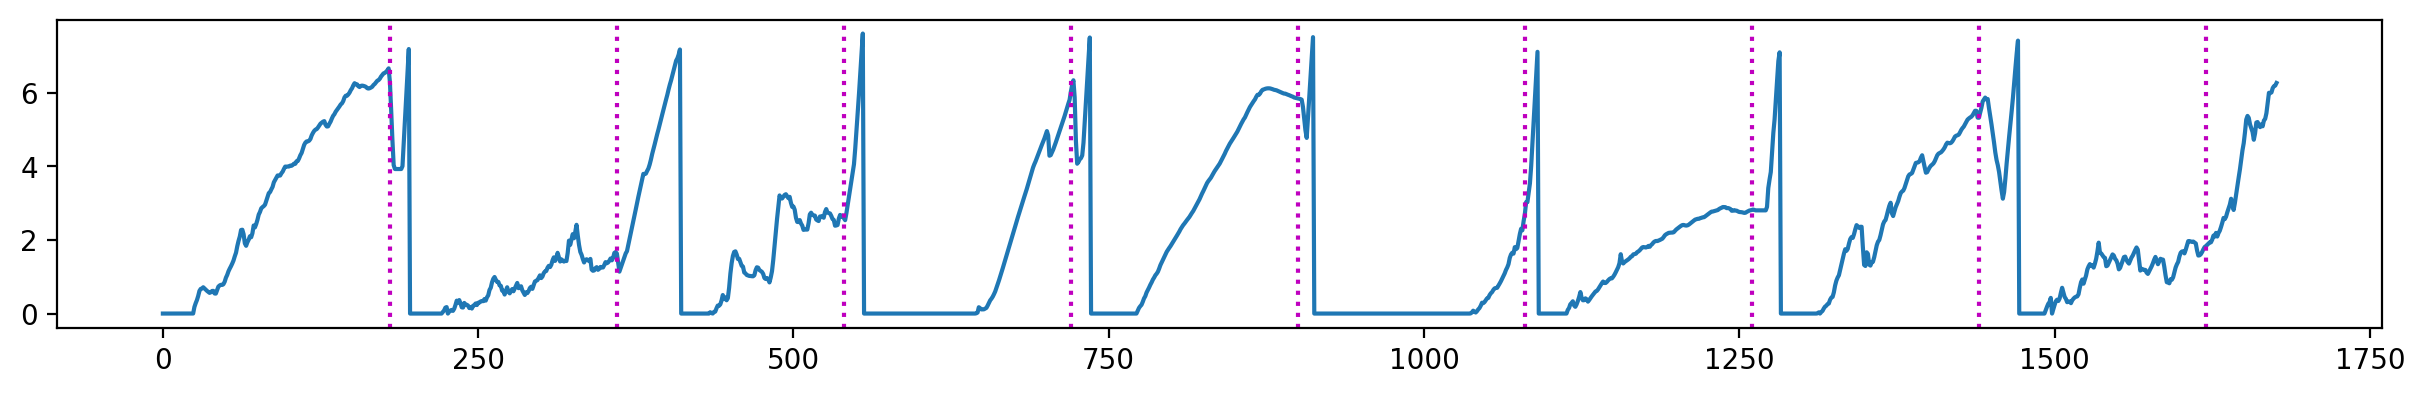

In [12]:
# Plot the test statistic on the train set
# Pink dotted lines correspond to true change points
plt.rcParams['figure.figsize'] = [15, 2]
plt.rcParams['figure.dpi'] = 200
plt.plot(S_ftal)
for i in range(len(change_points_val)):
    plt.axvline(change_points_val[i], c='m', ls=':')

In [15]:
#----------------------------------------------------
# Step 3: detect changes on the test part
#----------------------------------------------------

# Best hyperparameter after training
z = 7.0929117736832215
b = 0.4
    
# Change points on the validation set
change_points_test = change_points[change_points < test_end] - test_start
change_points_test = change_points_test[change_points_test > 0]
print('Test change points:', change_points_test)
    
# Initialization of the test statistic
S_ftal = np.empty(0)

# Initialization of the list of detected change points
change_points_ftal = []

# Initialization of the delays array and the false alarms counter
delays_ftal = np.empty(0)
current_change_point_ind = 0
false_alarms_ftal = 0

# Initialization
st_ftal = 0
new_st_ftal = 0
    
while new_st_ftal >= 0:

    # Run the procedure until the moment it reports a change point occurrence
    new_S_ftal, new_st_ftal = compute_test_stat_ftal(data_test[st_ftal + 1:], p, beta=b,\
                                                    design='multivariate', threshold=z)

    S_ftal = np.append(S_ftal, new_S_ftal)
    if new_st_ftal >= 0:
        st_ftal += new_st_ftal
        change_points_ftal += [int(st_ftal)]
    else:
        change_points_ftal += [int(data_test.shape[0] - 1)]

print('Detected change points:', change_points_ftal)
    
false_alarms_ftal, mean_delay_ftal, std_delay_ftal, not_detected_ftal\
= compute_delays(change_points_test, change_points_ftal)

print('FTAL, beta =', b, '. Number of false alarms:', false_alarms_ftal,\
    '; average delay:', np.round(mean_delay_ftal, 4), '±', np.round(std_delay_ftal, 4),\
    '; non-detected:', not_detected_ftal)

Test change points: [ 131  311  491  671  851 1032 1212]
Detected change points: [136, 233, 372, 431, 499, 706, 924, 1066, 1226, 1386, 1389]
FTAL, beta = 0.4 . Number of false alarms: 3 ; average delay: 32.8571 ± 24.3746 ; non-detected: 0


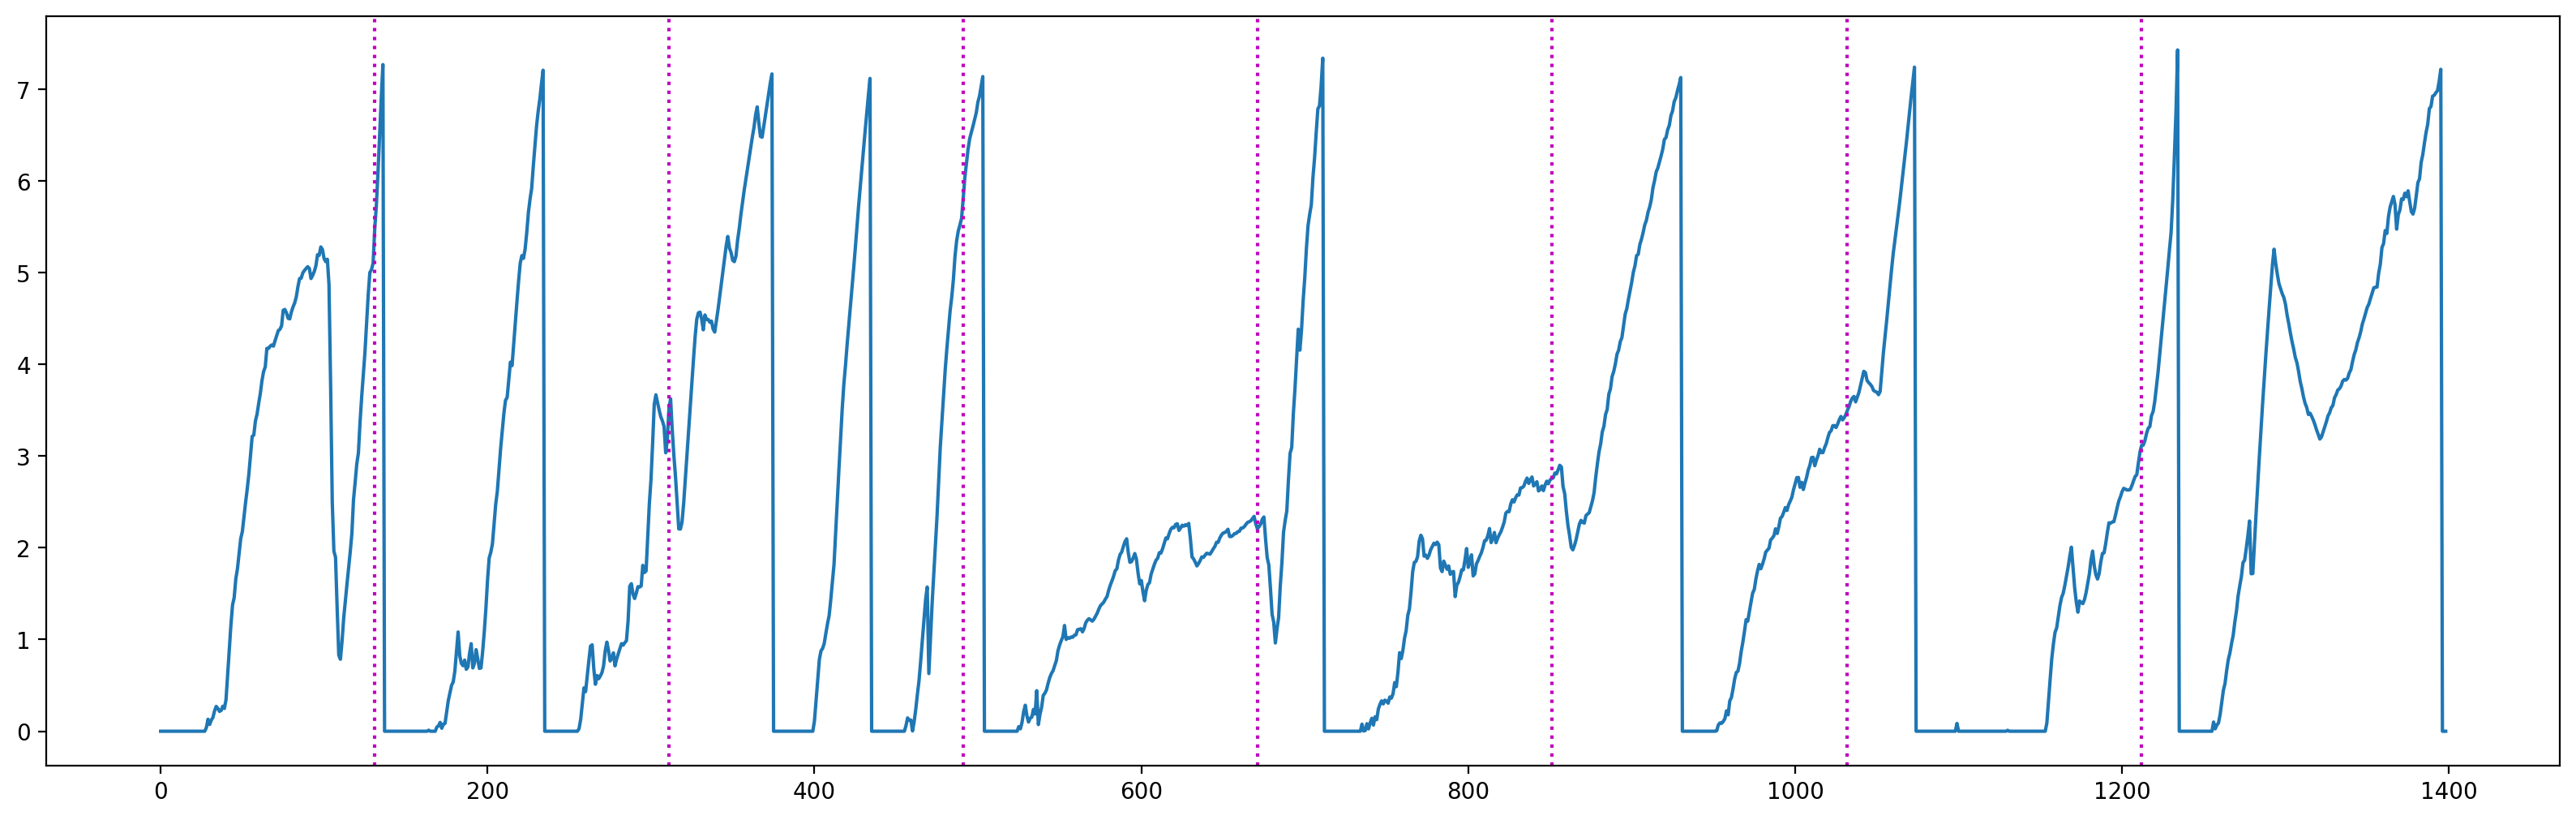

In [16]:
# Plot the test statistic on the test set
# Pink dotted lines correspond to true change points
plt.figure(figsize=(20, 6))
plt.plot(S_ftal)
for i in range(len(change_points_test)):
    plt.axvline(change_points_test[i], c='m', ls=':')

### KLIEP

In [74]:
# The list of hyperparameters
sigma_list = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


# Change points on the validation set
change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    

for sigma in sigma_list:
    
    #----------------------------------------------------
    # Step 1: tuning the threshold on the stationary part
    #----------------------------------------------------
    
    S_stationary = np.empty(0)
    for ds in data_stationary:
        
        S, _ = compute_test_stat_kliep(ds, window_size=50, sigma=sigma)
        S_stationary = np.append(S_stationary, S)
        
    # Set the threshold as the maximal value on the stationary part
    z = np.max(S_stationary)
    print(z)
    
    #----------------------------------------------------
    # Step 2: detect changes on the validation part
    #----------------------------------------------------

    # Initialization of the test statistic
    S_kliep = np.empty(0)

    # Initialization of the list of detected change points
    change_points_kliep = []

    # Initialization of the delays array and
    # the false alarms counter
    delays_kliep = np.empty(0)
    current_change_point_ind = 0
    false_alarms_kliep = 0

    # Initialization
    st_kliep = 0
    new_st_kliep = 0
    
    while new_st_kliep >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        
        new_S_kliep, new_st_kliep = compute_test_stat_kliep(data_val[st_kliep + 1:],\
                                                            window_size=50, sigma=sigma, threshold=z)

        S_kliep = np.append(S_kliep, new_S_kliep)

        if new_st_kliep >= 0:
            st_kliep += new_st_kliep
            change_points_kliep += [int(st_kliep)]
        else:
            change_points_kliep += [int(data_val.shape[0] - 1)]

    print('Detected change points:', change_points_kliep)
    
    false_alarms_kliep, mean_delay_kliep, std_delay_kliep, not_detected_kliep\
    = compute_delays(change_points_val, change_points_kliep)

    print('KLIEP, bandwidth =', sigma, '. Number of false alarms:', false_alarms_kliep,\
        '; average delay:', np.round(mean_delay_kliep, 4), '±', np.round(std_delay_kliep, 4),\
        '; non-detected:', not_detected_kliep)


Validation change points: [ 180  360  540  720  900 1080 1260 1440 1620]
29.350101170739254
Detected change points: [185, 361, 543, 723, 904, 1086, 1265, 1377, 1478, 1625, 1669]
KLIEP, bandwidth = 0.3 . Number of false alarms: 1 ; average delay: 7.7778 ± 10.7784 ; non-detected: 0
20.8217290578942
Detected change points: [184, 361, 543, 723, 904, 1084, 1264, 1400, 1501, 1624, 1669]
KLIEP, bandwidth = 0.4 . Number of false alarms: 1 ; average delay: 9.7778 ± 18.1339 ; non-detected: 0
16.835753725095255
Detected change points: [183, 361, 544, 723, 904, 1083, 1264, 1452, 1623, 1669]
KLIEP, bandwidth = 0.5 . Number of false alarms: 0 ; average delay: 4.1111 ± 2.9229 ; non-detected: 0
14.998209095576426
Detected change points: [183, 361, 544, 724, 906, 1083, 1265, 1455, 1623, 1669]
KLIEP, bandwidth = 0.6 . Number of false alarms: 0 ; average delay: 4.8889 ± 3.8136 ; non-detected: 0
12.697352100146352
Detected change points: [184, 360, 544, 725, 908, 1083, 1266, 1456, 1622, 1669]
KLIEP, bandw

In [75]:
# TRAIN

# Best hyperparameter for training
sigma = 0.5
# z = 16.835753725095255

# Change points on the validation set
change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
#----------------------------------------------------
# Step 1: tuning the threshold on the stationary part
#----------------------------------------------------

S_stationary = np.empty(0)
for ds in data_stationary:
    
    S, _ = compute_test_stat_kliep(ds, window_size=50, sigma=sigma)
    S_stationary = np.append(S_stationary, S)
    
# Set the threshold as the maximal value on the stationary part
z = np.max(S_stationary)
print(z)

#----------------------------------------------------
# Step 2: detect changes on the validation part
#----------------------------------------------------

# Initialization of the test statistic
S_kliep = np.empty(0)

# Initialization of the list of detected change points
change_points_kliep = []

# Initialization of the delays array and
# the false alarms counter
delays_kliep = np.empty(0)
current_change_point_ind = 0
false_alarms_kliep = 0

# Initialization
st_kliep = 0
new_st_kliep = 0

while new_st_kliep >= 0:

    # Run the procedure until the moment
    # it reports a change point occurrence
    new_S_kliep, new_st_kliep = compute_test_stat_kliep(data_val[st_kliep + 1:],\
                                                        window_size=50, sigma=sigma, threshold=z)

    S_kliep = np.append(S_kliep, new_S_kliep)

    if new_st_kliep >= 0:
        st_kliep += new_st_kliep
        change_points_kliep += [int(st_kliep)]
    else:
        change_points_kliep += [int(data_val.shape[0] - 1)]

print('Detected change points:', change_points_kliep)

false_alarms_kliep, mean_delay_kliep, std_delay_kliep, not_detected_kliep\
= compute_delays(change_points_val, change_points_kliep)

print('KLIEP, bandwidth =', sigma, '. Number of false alarms:', false_alarms_kliep,\
    '; average delay:', np.round(mean_delay_kliep, 4), '±', np.round(std_delay_kliep, 4),\
    '; non-detected:', not_detected_kliep)


Validation change points: [ 180  360  540  720  900 1080 1260 1440 1620]
16.835753725095255
Detected change points: [183, 361, 544, 723, 904, 1083, 1264, 1452, 1623, 1669]
KLIEP, bandwidth = 0.5 . Number of false alarms: 0 ; average delay: 4.1111 ± 2.9229 ; non-detected: 0


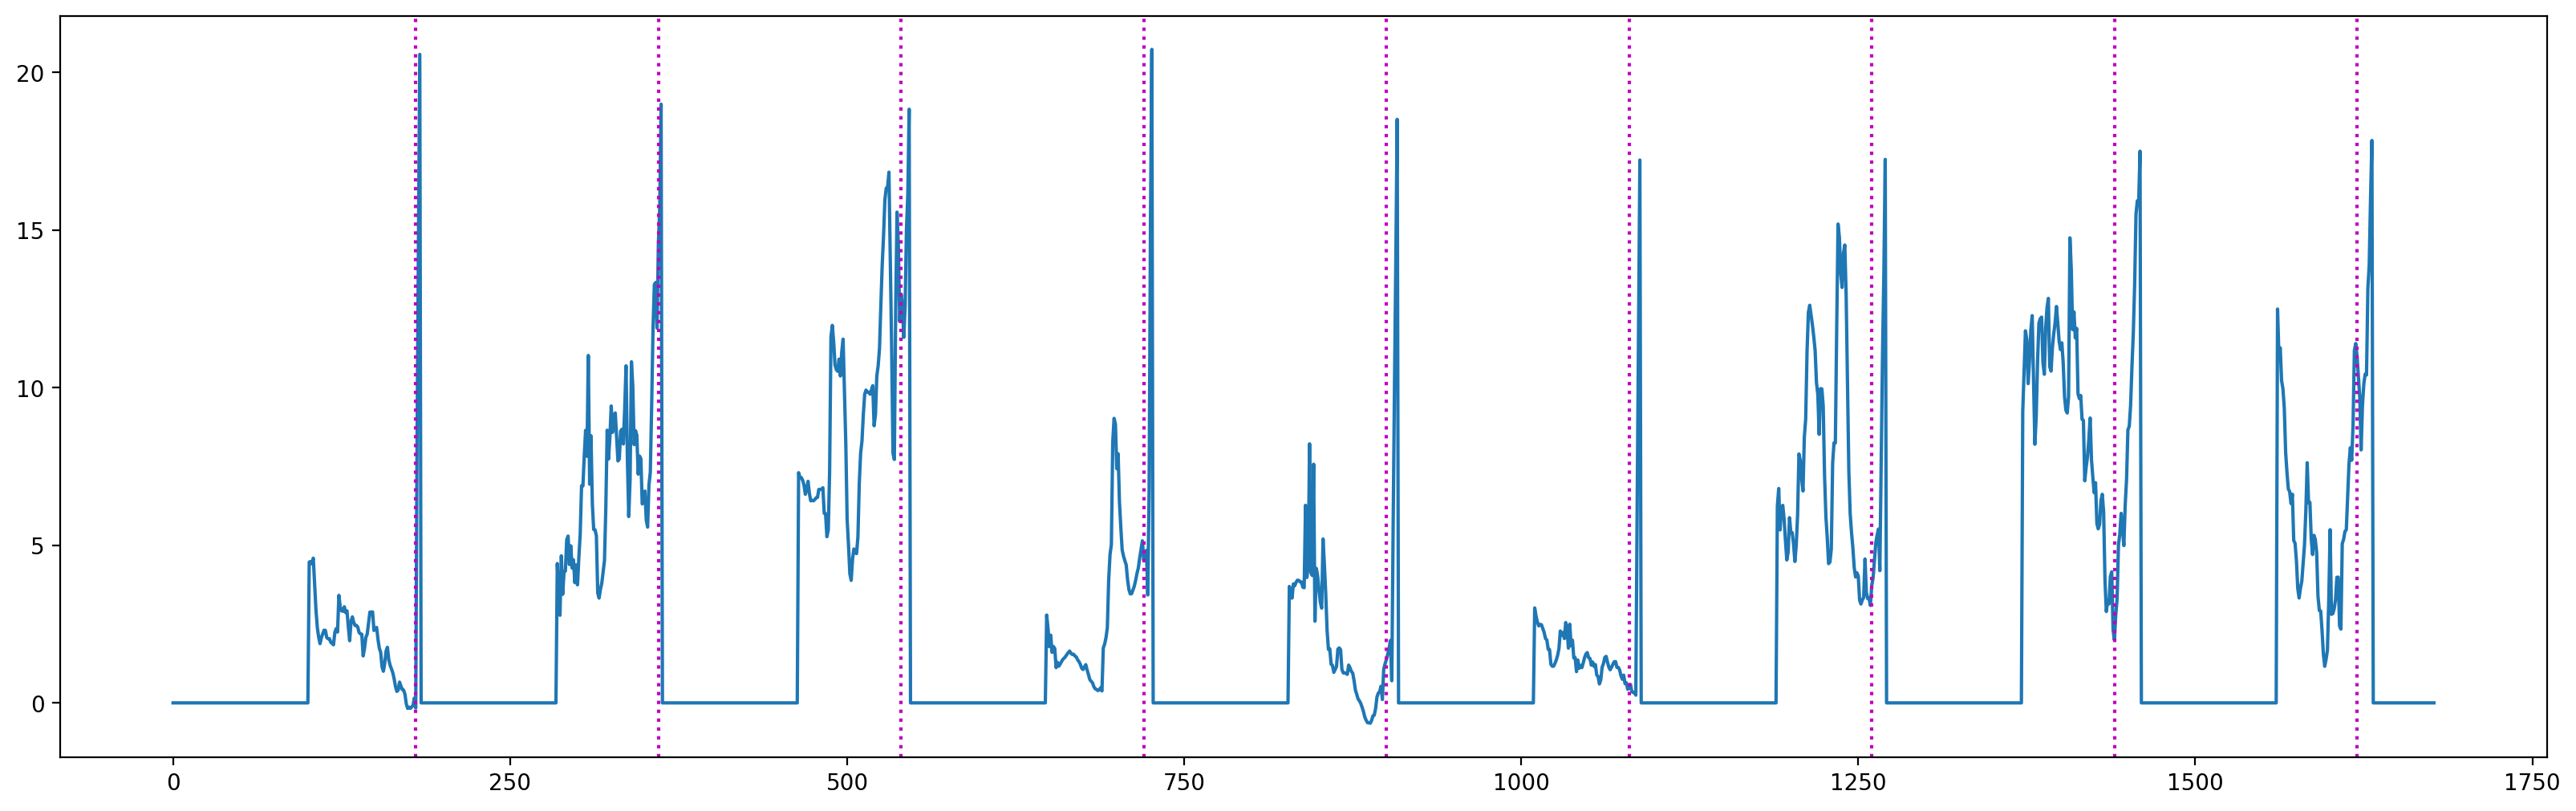

In [76]:
# Plot the test statistic on the train set
# Pink dotted lines correspond to true change points
plt.figure(figsize=(20, 6))
plt.plot(S_kliep)
for i in range(len(change_points_val)):
    plt.axvline(change_points_val[i], c='m', ls=':')

In [86]:
#----------------------------------------------------
# Step 3: detect changes on the test part
#----------------------------------------------------

# Best hyperparameter after training
z = 16.835753725095255
sigma = 0.5
    
# Change points on the validation set
change_points_test = change_points[change_points < test_end] - test_start
change_points_test = change_points_test[change_points_test > 0]
print('Test change points:', change_points_test)

# Initialization of the test statistic
S_kliep = np.empty(0)

# Initialization of the list of detected change points
change_points_kliep = []

# Initialization of the delays array and
# the false alarms counter
delays_kliep = np.empty(0)
current_change_point_ind = 0
false_alarms_kliep = 0

# Initialization
st_kliep = 0
new_st_kliep = 0
    
while new_st_kliep >= 0:

    # Run the procedure until the moment 
    # it reports a change point occurrence
    
    new_S_kliep, new_st_kliep = compute_test_stat_kliep(data_test[st_kliep + 1:],\
                                                        window_size=50, sigma=sigma, threshold=z)

    S_kliep = np.append(S_kliep, new_S_kliep)

    if new_st_kliep >= 0:
        st_kliep += new_st_kliep
        change_points_kliep += [int(st_kliep)]
    else:
        change_points_kliep += [int(data_test.shape[0] - 1)]

print('Detected change points:', change_points_kliep)
    
false_alarms_kliep, mean_delay_kliep, std_delay_kliep, not_detected_kliep\
= compute_delays(change_points_test, change_points_kliep)

print('KLIEP, bandwidth =', sigma, '. Number of false alarms:', false_alarms_kliep,\
      '; average delay:', np.round(mean_delay_kliep, 4), '±', np.round(std_delay_kliep, 4),\
      '; non-detected:', not_detected_kliep)

Test change points: [ 131  311  491  671  851 1032 1212]


/Users/annal/.pyenv/versions/3.10.10/lib/python3.10/site-packages/cvxpy/atoms/elementwise/log.py:35: RuntimeWarning: invalid value encountered in log
  return np.log(values[0])


Detected change points: [121, 228, 329, 430, 532, 679, 780, 881, 1036, 1220, 1321, 1389]
KLIEP, bandwidth = 0.5 . Number of false alarms: 4 ; average delay: 29.4286 ± 30.227 ; non-detected: 0


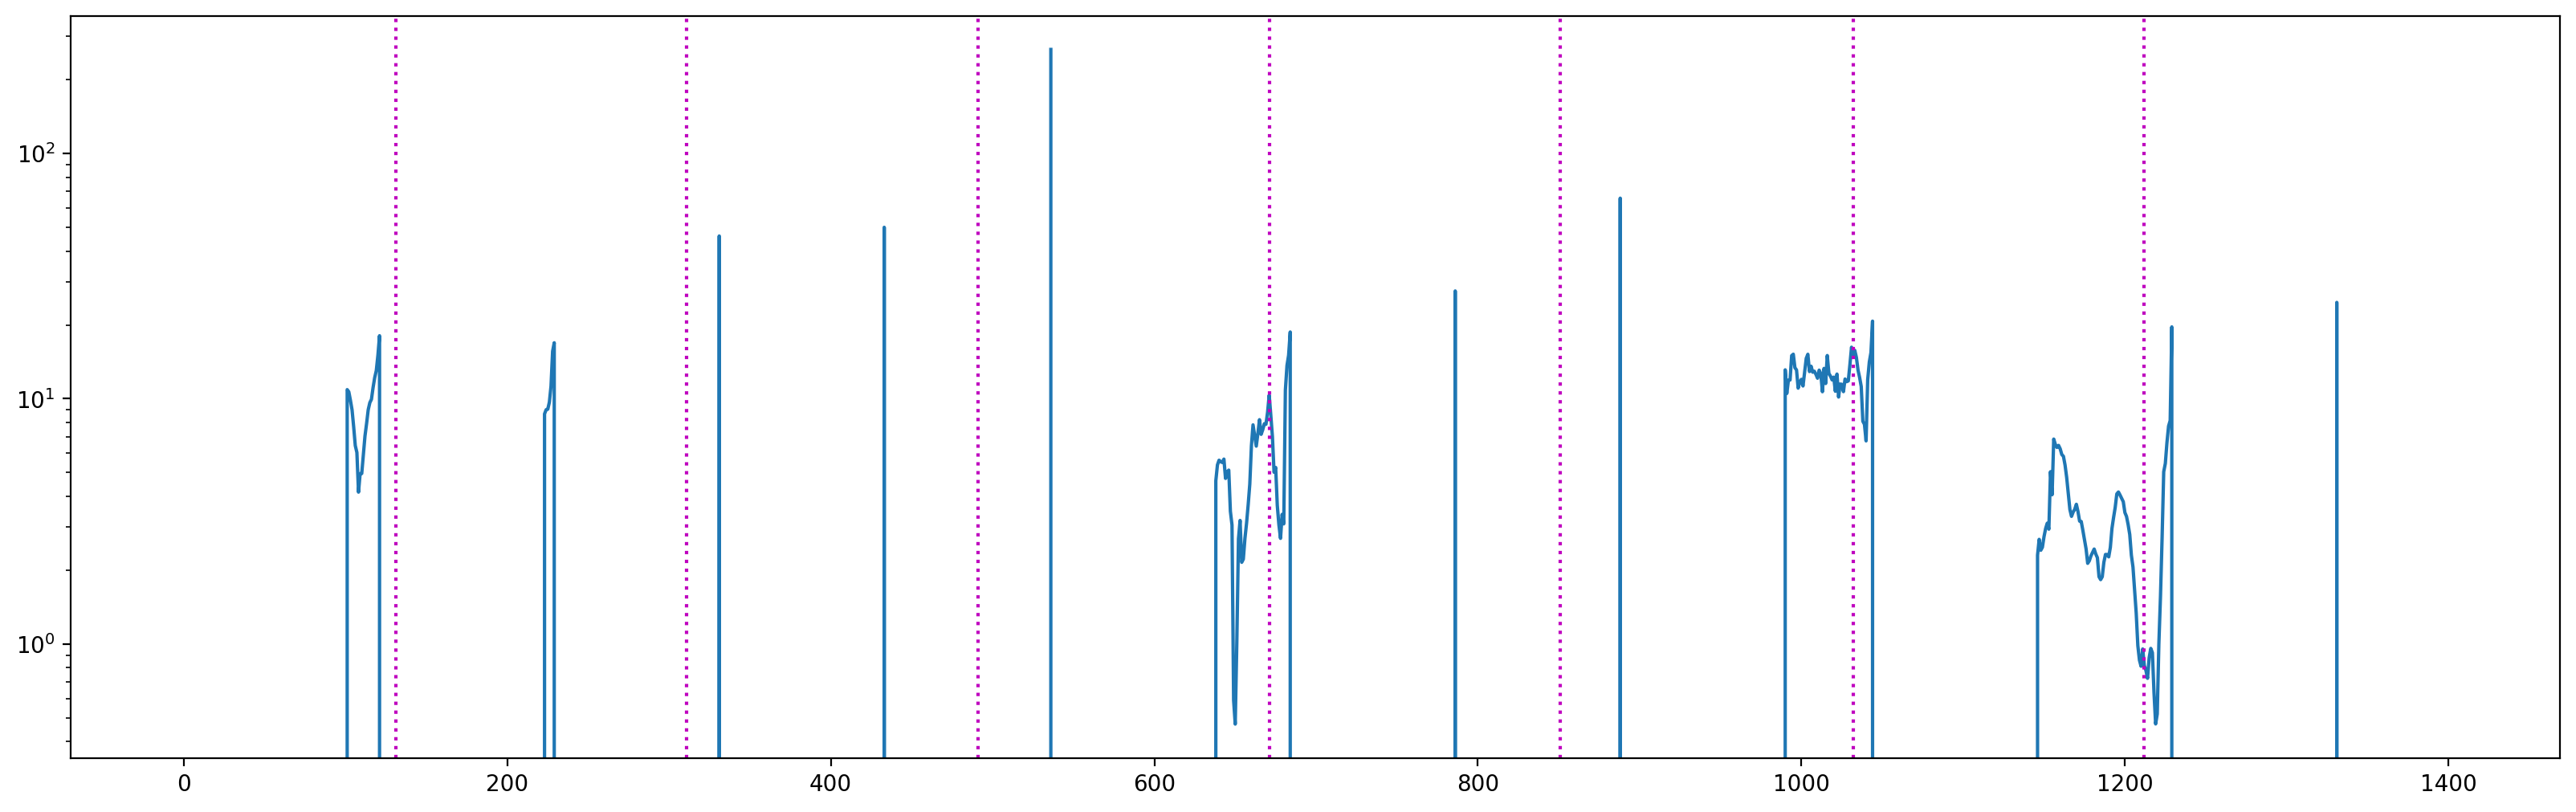

In [87]:
# Plot the test statistic on the test set
# Pink dotted lines correspond to true change points
plt.figure(figsize=(20, 6))
plt.plot(S_kliep)
plt.yscale('log')
for i in range(len(change_points_test)):
    plt.axvline(change_points_test[i], c='m', ls=':')

### Kernel change point detector with M-statistic

In [88]:
# The list of hyperparameters
sigma_list = [10, 20, 25, 40, 50]

# Change points on the validation set
change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
for sigma in sigma_list:
    
    #----------------------------------------------------
    # Step 1: tuning the threshold on the stationary part
    #----------------------------------------------------
    
    S_stationary = np.empty(0)
    for ds in data_stationary:
        
        S, _ = compute_test_stat_mmd(ds, window_size=50, sigma=sigma)
        S_stationary = np.append(S_stationary, S)
        
    # Set the threshold as the maximal value on the stationary part
    z = np.max(S_stationary)
    print(z)
    
    #----------------------------------------------------
    # Step 2: detect changes on the validation part
    #----------------------------------------------------
    
    # Initialization of the test statistic
    S_mmd = np.empty(0)

    # Initialization of the list of detected change points
    change_points_mmd = []

    # Initialization of the delays array and
    # the false alarms counter
    delays_mmd = np.empty(0)
    current_change_point_ind = 0
    false_alarms_mmd = 0

    # Initialization
    st_mmd = 0
    new_st_mmd = 0
    
    while new_st_mmd >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        new_S_mmd, new_st_mmd = compute_test_stat_mmd(data_val[st_mmd + 1:],\
                                                            window_size=50, sigma=sigma, threshold=z)

        S_mmd = np.append(S_mmd, new_S_mmd)

        if new_st_mmd >= 0:
            st_mmd += new_st_mmd
            change_points_mmd += [int(st_mmd)]
        else:
            change_points_mmd += [int(data_val.shape[0] - 1)]

    print('Detected change points:', change_points_mmd)
    
    false_alarms_mmd, mean_delay_mmd, std_delay_mmd, not_detected_mmd\
    = compute_delays(change_points_val, change_points_mmd)

    print('M-statistic, bandwidth =', sigma, '. Number of false alarms:', false_alarms_mmd,\
          '; average delay:', np.round(mean_delay_mmd, 4), '±', np.round(std_delay_mmd, 4),\
          '; non-detected:', not_detected_mmd)

Validation change points: [ 180  360  540  720  900 1080 1260 1440 1620]
0.3314497674138291
Detected change points: [188, 359, 547, 729, 912, 1093, 1278, 1461, 1624, 1669]
M-statistic, bandwidth = 10 . Number of false alarms: 1 ; average delay: 30.2222 ± 53.1952 ; non-detected: 1
0.08510817427581908
Detected change points: [188, 359, 547, 729, 912, 1093, 1278, 1461, 1624, 1669]
M-statistic, bandwidth = 20 . Number of false alarms: 1 ; average delay: 30.2222 ± 53.1952 ; non-detected: 1
0.05464743778231355
Detected change points: [188, 359, 547, 729, 912, 1093, 1278, 1461, 1624, 1669]
M-statistic, bandwidth = 25 . Number of false alarms: 1 ; average delay: 30.2222 ± 53.1952 ; non-detected: 1
0.021422626064712173
Detected change points: [188, 359, 547, 729, 912, 1093, 1280, 1461, 1624, 1669]
M-statistic, bandwidth = 40 . Number of false alarms: 1 ; average delay: 30.4444 ± 53.1478 ; non-detected: 1
0.013721754051851168
Detected change points: [188, 359, 547, 729, 912, 1093, 1280, 1461, 16

In [89]:
# The list of hyperparameters
sigma_list = np.linspace(1, 10, 10)

# Change points on the validation set
change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
for sigma in sigma_list:
    
    #----------------------------------------------------
    # Step 1: tuning the threshold on the stationary part
    #----------------------------------------------------
    
    S_stationary = np.empty(0)
    for ds in data_stationary:
        
        S, _ = compute_test_stat_mmd(ds, window_size=50, sigma=sigma)
        S_stationary = np.append(S_stationary, S)
        
    # Set the threshold as the maximal value on the stationary part
    z = np.max(S_stationary)
    print(z)
    
    #----------------------------------------------------
    # Step 2: detect changes on the validation part
    #----------------------------------------------------
    
    # Initialization of the test statistic
    S_mmd = np.empty(0)

    # Initialization of the list of detected change points
    change_points_mmd = []

    # Initialization of the delays array and
    # the false alarms counter
    delays_mmd = np.empty(0)
    current_change_point_ind = 0
    false_alarms_mmd = 0

    # Initialization
    st_mmd = 0
    new_st_mmd = 0
    
    while new_st_mmd >= 0:

        # Run the procedure until the moment
        # it reports a change point occurrence
        new_S_mmd, new_st_mmd = compute_test_stat_mmd(data_val[st_mmd + 1:],\
                                                            window_size=50, sigma=sigma, threshold=z)

        S_mmd = np.append(S_mmd, new_S_mmd)

        if new_st_mmd >= 0:
            st_mmd += new_st_mmd
            change_points_mmd += [int(st_mmd)]
        else:
            change_points_mmd += [int(data_val.shape[0] - 1)]

    print('Detected change points:', change_points_mmd)
    
    false_alarms_mmd, mean_delay_mmd, std_delay_mmd, not_detected_mmd\
    = compute_delays(change_points_val, change_points_mmd)

    print('M-statistic, bandwidth =', sigma, '. Number of false alarms:', false_alarms_mmd,\
          '; average delay:', np.round(mean_delay_mmd, 4), '±', np.round(std_delay_mmd, 4),\
          '; non-detected:', not_detected_mmd)

Validation change points: [ 180  360  540  720  900 1080 1260 1440 1620]
8.681351176068661
Detected change points: [187, 372, 546, 726, 906, 1089, 1235, 1336, 1463, 1611, 1669]
M-statistic, bandwidth = 1.0 . Number of false alarms: 2 ; average delay: 21.5556 ± 23.3481 ; non-detected: 0
3.459323847526048
Detected change points: [186, 361, 545, 726, 908, 1089, 1271, 1372, 1473, 1610, 1669]
M-statistic, bandwidth = 2.0 . Number of false alarms: 2 ; average delay: 14.2222 ± 15.0317 ; non-detected: 0
2.9002480934797057
Detected change points: [188, 361, 547, 728, 910, 1093, 1275, 1457, 1623, 1669]
M-statistic, bandwidth = 3.0 . Number of false alarms: 0 ; average delay: 9.1111 ± 4.9765 ; non-detected: 0
1.8039926804321358
Detected change points: [188, 359, 547, 729, 911, 1093, 1277, 1460, 1624, 1669]
M-statistic, bandwidth = 4.0 . Number of false alarms: 1 ; average delay: 29.8889 ± 53.2801 ; non-detected: 1
1.2010265981256405
Detected change points: [188, 359, 547, 729, 911, 1093, 1277, 14

In [9]:
# TRAIN

# Best hyperparameter for training
sigma = 3
# z = 2.9002480934797057

# Change points on the validation set
change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
#----------------------------------------------------
# Step 1: tuning the threshold on the stationary part
#----------------------------------------------------

S_stationary = np.empty(0)
for ds in data_stationary:
    
    S, _ = compute_test_stat_mmd(ds, window_size=50, sigma=sigma)
    S_stationary = np.append(S_stationary, S)
    
# Set the threshold as the maximal value on the stationary part
z = np.max(S_stationary)
print(z)

#----------------------------------------------------
# Step 2: detect changes on the validation part
#----------------------------------------------------

# Initialization of the test statistic
S_mmd = np.empty(0)

# Initialization of the list of detected change points
change_points_mmd = []

# Initialization of the delays array and
# the false alarms counter
delays_mmd = np.empty(0)
current_change_point_ind = 0
false_alarms_mmd = 0

# Initialization
st_mmd = 0
new_st_mmd = 0

while new_st_mmd >= 0:

    # Run the procedure until the moment
    # it reports a change point occurrence
    new_S_mmd, new_st_mmd = compute_test_stat_mmd(data_val[st_mmd + 1:],\
                                                        window_size=50, sigma=sigma, threshold=z)

    S_mmd = np.append(S_mmd, new_S_mmd)

    if new_st_mmd >= 0:
        st_mmd += new_st_mmd
        change_points_mmd += [int(st_mmd)]
    else:
        change_points_mmd += [int(data_val.shape[0] - 1)]

print('Detected change points:', change_points_mmd)

false_alarms_mmd, mean_delay_mmd, std_delay_mmd, not_detected_mmd\
= compute_delays(change_points_val, change_points_mmd)

print('M-statistic, bandwidth =', sigma, '. Number of false alarms:', false_alarms_mmd,\
        '; average delay:', np.round(mean_delay_mmd, 4), '±', np.round(std_delay_mmd, 4),\
        '; non-detected:', not_detected_mmd)

Validation change points: [ 180  360  540  720  900 1080 1260 1440 1620]
2.9002480934797616
Detected change points: [188, 361, 547, 728, 910, 1093, 1275, 1457, 1623, 1669]
M-statistic, bandwidth = 3 . Number of false alarms: 0 ; average delay: 9.1111 ± 4.9765 ; non-detected: 0


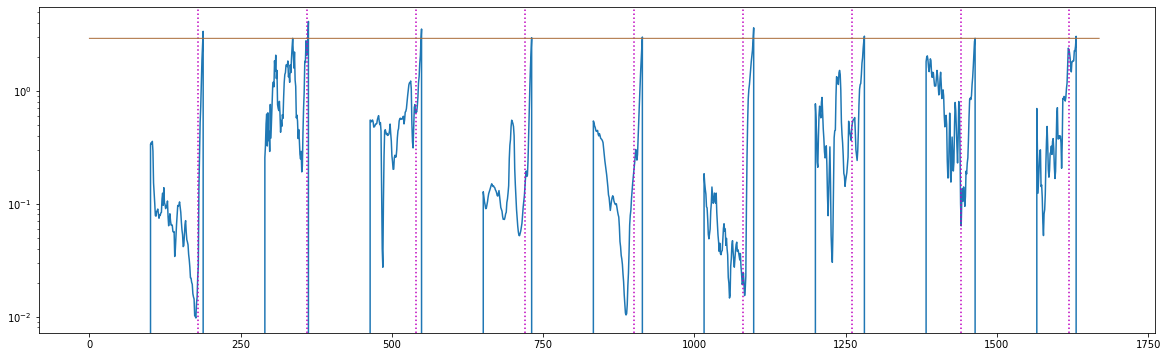

In [10]:
# Plot the test statistic on the test set
# Pink dotted lines correspond to true change points
plt.figure(figsize=(20, 6))
plt.plot(S_mmd)
plt.yscale('log')
for i in range(len(change_points_val)):
    plt.axvline(change_points_val[i], c='m', ls=':')
plt.plot([z] * data_val.shape[0], color='#aa6c39', lw=1)#, label="threshold")

In [97]:
#----------------------------------------------------
# Step 3: detect changes on the test part
#----------------------------------------------------

# Best hyperparameter after training
z = 2.9002480934797057
sigma = 3
    
# Change points on the validation set
change_points_test = change_points[change_points < test_end] - test_start
change_points_test = change_points_test[change_points_test > 0]
print('Test change points:', change_points_test)

# Initialization of the test statistic
S_mmd = np.empty(0)

# Initialization of the list of detected change points
change_points_mmd = []

# Initialization of the delays array and
# the false alarms counter
delays_mmd = np.empty(0)
current_change_point_ind = 0
false_alarms_mmd = 0

# Initialization
st_mmd = 0
new_st_mmd = 0
    
while new_st_mmd >= 0:

    # Run the procedure until the moment it reports a change point occurrence
    new_S_mmd, new_st_mmd = compute_test_stat_mmd(data_test[st_mmd + 1:],\
                                                        window_size=50, sigma=sigma, threshold=z)

    S_mmd = np.append(S_mmd, new_S_mmd)

    if new_st_mmd >= 0:
        st_mmd += new_st_mmd
        change_points_mmd += [int(st_mmd)]
    else:
        change_points_mmd += [int(data_test.shape[0] - 1)]

print('Detected change points:', change_points_mmd)
    
false_alarms_mmd, mean_delay_mmd, std_delay_mmd, not_detected_mmd\
= compute_delays(change_points_test, change_points_mmd)

print('M-statistic, bandwidth =', sigma, '. Number of false alarms:', false_alarms_mmd,\
      '; average delay:', np.round(mean_delay_mmd, 4), '±', np.round(std_delay_mmd, 4),\
      '; non-detected:', not_detected_mmd)

Test change points: [ 131  311  491  671  851 1032 1212]
Detected change points: [132, 321, 422, 523, 689, 856, 984, 1085, 1237, 1338, 1389]
M-statistic, bandwidth = 3 . Number of false alarms: 3 ; average delay: 20.5714 ± 16.6721 ; non-detected: 0


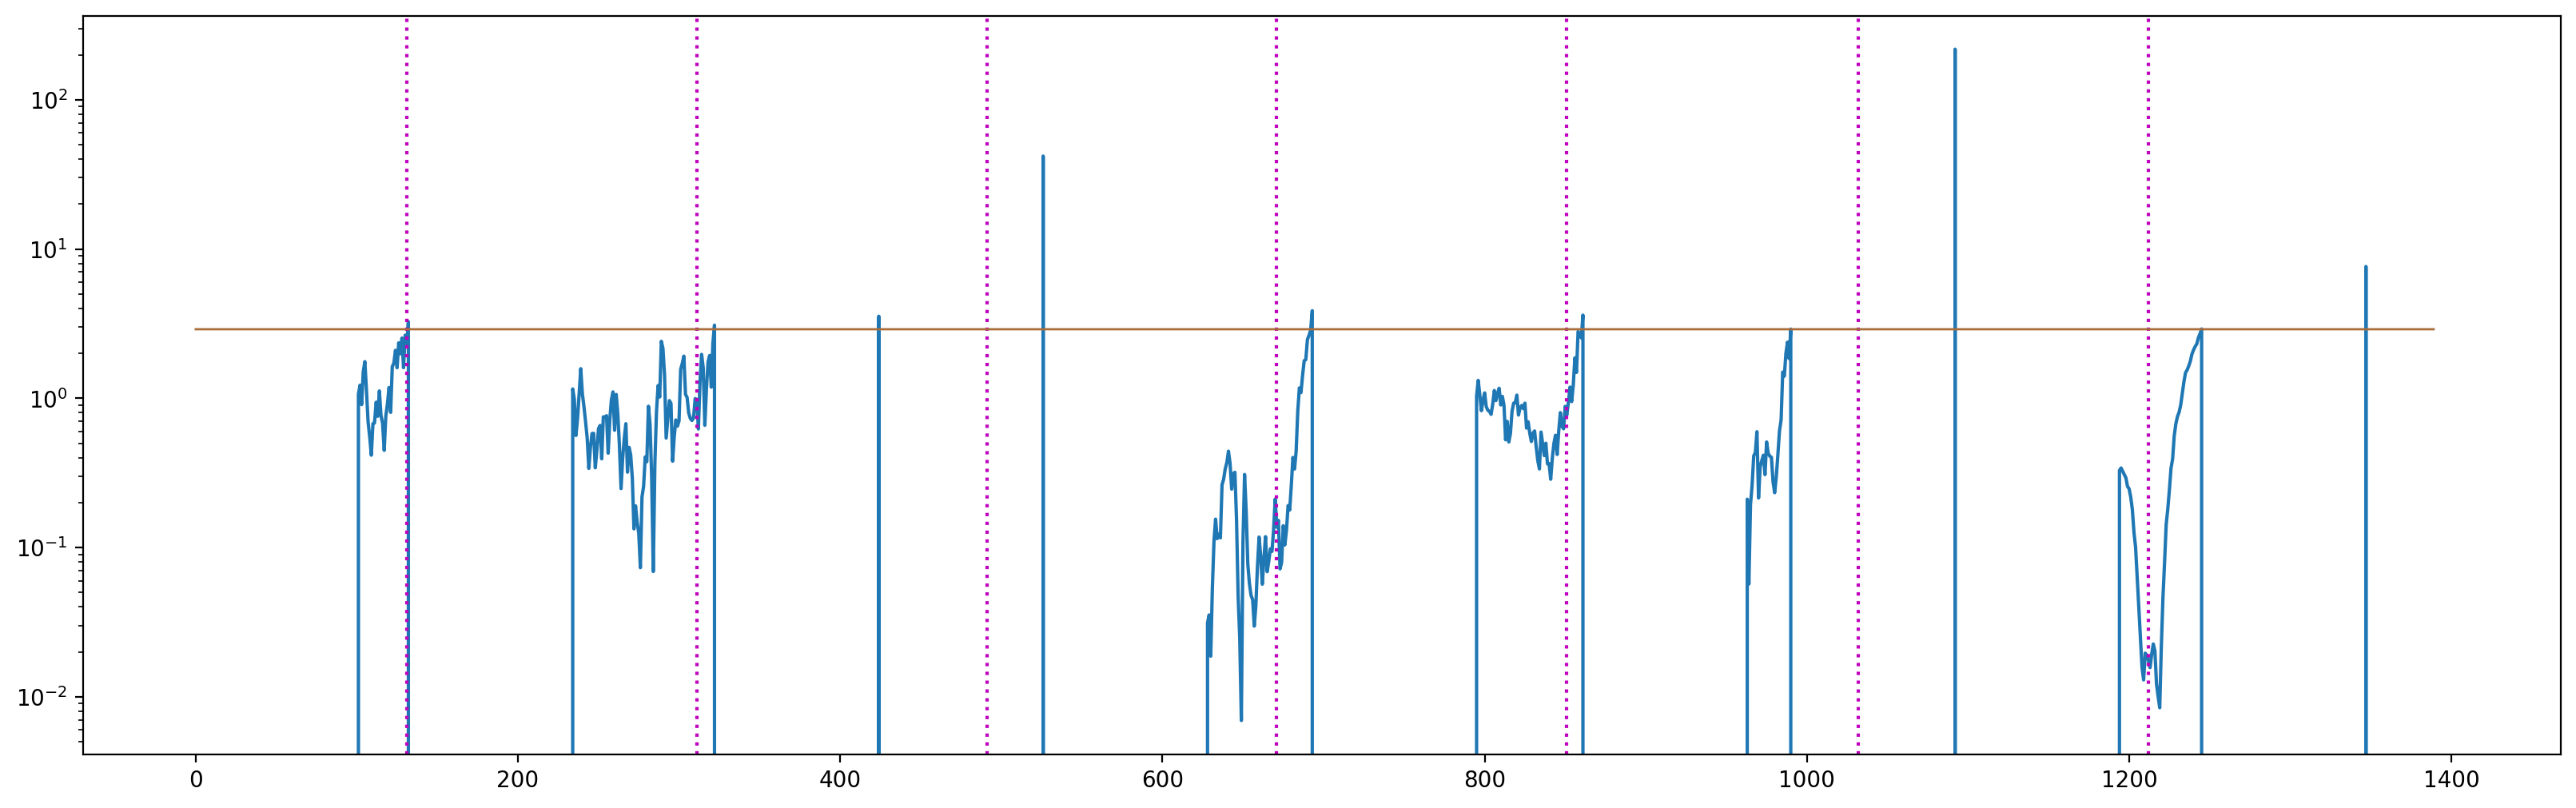

In [98]:
# Plot the test statistic on the test set
# Pink dotted lines correspond to true change points
plt.figure(figsize=(20, 6))
plt.plot(S_mmd)
plt.yscale('log')
for i in range(len(change_points_test)):
    plt.axvline(change_points_test[i], c='m', ls=':')
plt.plot([z] * data_test.shape[0], color='#aa6c39', lw=1)#, label="threshold")

### PLOTS


#### Score-based

In [16]:
# TRAIN

eta = 0.1
l = 0.95
a = 1e-5
z = 36.19631395342578
dim=3

change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
print('threshold =', z)

S_q_train = np.empty(0)
change_points_q = []
st_q = 0
new_st_q = 0

while new_st_q >= 0:
    X = data_val[st_q + 1:].copy()
    n = X.shape[0]
    model = ChangePointDetector(d_dim=dim*2, x_dim=dim, lambda_=l, alpha=a, basis=PolyBasis(2, dim), threshold=z)
    new_S_q, new_st_q = model.run(X.reshape((n, dim, 1)), eta)  

    S_q_train = np.append(S_q_train, new_S_q)

    if new_st_q >= 0:
        st_q += new_st_q
        change_points_q += [int(st_q)]
    else:
        change_points_q += [int(data_val.shape[0] - 1)]

print('Detected change points:', change_points_q)

false_alarms_q, mean_delay_q, std_delay_q, not_detected_q\
= compute_delays(change_points_val, change_points_q)

print(f'q, eta={eta}, lambda =', l, '; alpha = ', a,  '. Number of false alarms:', false_alarms_q,\
    '; average delay:', np.round(mean_delay_q, 4), '±', np.round(std_delay_q, 4),\
    '; non-detected:', not_detected_q)

Validation change points: [ 180  360  540  720  900 1080 1260 1440 1620]
threshold = 36.19631395342578
Detected change points: [182, 376, 470, 544, 722, 902, 1083, 1268, 1444, 1669]
q, eta=0.1, lambda = 0.95 ; alpha =  1e-05 . Number of false alarms: 1 ; average delay: 10.0 ± 14.4299 ; non-detected: 0


In [17]:
# TEST

eta = 0.1
lambda_ = 0.95
alpha = 1e-5
dim=3
z = 36.19631395342578

change_points_test = change_points[change_points < test_end] - test_start
change_points_test = change_points_test[change_points_test > 0]
print('Test change points:', change_points_test)
print('threshold =', z)

S_q_test = np.empty(0)
change_points_q = []
st_q = 0
new_st_q = 0
    
while new_st_q >= 0:
    X = data_test[st_q + 1:].copy()
    n = X.shape[0]
    model = ChangePointDetector(d_dim=dim*2, x_dim=dim, lambda_=lambda_, alpha=alpha, basis=PolyBasis(2, dim), threshold=z)
    new_S_q, new_st_q = model.run(X.reshape((n, dim, 1)), eta)  

    S_q_test = np.append(S_q_test, new_S_q)

    if new_st_q >= 0:
        st_q += new_st_q
        change_points_q += [int(st_q)]
    else:
        change_points_q += [int(data_test.shape[0] - 1)]

print('Detected change points:', change_points_q)
    
false_alarms_q, mean_delay_q, std_delay_q, not_detected_q\
= compute_delays(change_points_test, change_points_q)

print('Score-based quadratic basis. Number of false alarms:', false_alarms_q,\
      '; average delay:', np.round(mean_delay_q, 4), '±', np.round(std_delay_q, 4),\
      '; non-detected:', not_detected_q)

Test change points: [ 131  311  491  671  851 1032 1212]
threshold = 36.19631395342578
Detected change points: [200, 320, 494, 676, 890, 1035, 1220, 1389]
Score-based quadratic basis. Number of false alarms: 0 ; average delay: 19.4286 ± 23.3841 ; non-detected: 0


#### FALCON

In [18]:
# TRAIN
p = 1
b = 0.4
z = 7.0929117736832215

change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
print('threshold =', z)

S_ftal_train = np.empty(0)
change_points_ftal = []
st_ftal = 0
new_st_ftal = 0

while new_st_ftal >= 0:

    new_S_ftal, new_st_ftal = compute_test_stat_ftal(data_val[st_ftal + 1:], p, beta=b,\
                                                    design='multivariate', threshold=z)

    S_ftal_train = np.append(S_ftal_train, new_S_ftal)
    if new_st_ftal >= 0:
        st_ftal += new_st_ftal
        change_points_ftal += [int(st_ftal)]
    else:
        change_points_ftal += [int(data_val.shape[0] - 1)]

print('Detected change points:', change_points_ftal)

false_alarms_ftal, mean_delay_ftal, std_delay_ftal, not_detected_ftal\
= compute_delays(change_points_val, change_points_ftal)

print('FTAL, beta =', b, '. Number of false alarms:', false_alarms_ftal,\
        '; average delay:', np.round(mean_delay_ftal, 4), '±', np.round(std_delay_ftal, 4),\
        '; non-detected:', not_detected_ftal)


Validation change points: [ 180  360  540  720  900 1080 1260 1440 1620]
threshold = 7.0929117736832215
Detected change points: [195, 409, 553, 732, 908, 1085, 1276, 1464, 1669]
FTAL, beta = 0.4 . Number of false alarms: 0 ; average delay: 21.2222 ± 15.6615 ; non-detected: 0


In [19]:
# TEST
b = 0.4
z = 7.0929117736832215

change_points_test = change_points[change_points < test_end] - test_start
change_points_test = change_points_test[change_points_test > 0]
print('Test change points:', change_points_test)
print('threshold =', z)

S_ftal_test = np.empty(0)
change_points_ftal = []
st_ftal = 0
new_st_ftal = 0
    
while new_st_ftal >= 0:

    new_S_ftal, new_st_ftal = compute_test_stat_ftal(data_test[st_ftal + 1:], p, beta=b,\
                                                    design='multivariate', threshold=z)
    S_ftal_test = np.append(S_ftal_test, new_S_ftal)
    if new_st_ftal >= 0:
        st_ftal += new_st_ftal
        change_points_ftal += [int(st_ftal)]
    else:
        change_points_ftal += [int(data_test.shape[0] - 1)]

print('Detected change points:', change_points_ftal)
    
false_alarms_ftal, mean_delay_ftal, std_delay_ftal, not_detected_ftal\
= compute_delays(change_points_test, change_points_ftal)

print('FTAL, beta =', b, '. Number of false alarms:', false_alarms_ftal,\
    '; average delay:', np.round(mean_delay_ftal, 4), '±', np.round(std_delay_ftal, 4),\
    '; non-detected:', not_detected_ftal)

Test change points: [ 131  311  491  671  851 1032 1212]
threshold = 7.0929117736832215
Detected change points: [136, 233, 372, 431, 499, 706, 924, 1066, 1226, 1386, 1389]
FTAL, beta = 0.4 . Number of false alarms: 3 ; average delay: 32.8571 ± 24.3746 ; non-detected: 0


#### KLIEP

In [20]:
# TRAIN
sigma = 0.5
z = 16.835753725095255

change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
print('threshold =', z)

S_kliep_train = np.empty(0)
change_points_kliep = []
st_kliep = 0
new_st_kliep = 0

while new_st_kliep >= 0:

    new_S_kliep, new_st_kliep = compute_test_stat_kliep(data_val[st_kliep + 1:],\
                                                        window_size=50, sigma=sigma, threshold=z)
    S_kliep_train = np.append(S_kliep_train, new_S_kliep)
    if new_st_kliep >= 0:
        st_kliep += new_st_kliep
        change_points_kliep += [int(st_kliep)]
    else:
        change_points_kliep += [int(data_val.shape[0] - 1)]

print('Detected change points:', change_points_kliep)

false_alarms_kliep, mean_delay_kliep, std_delay_kliep, not_detected_kliep\
= compute_delays(change_points_val, change_points_kliep)

print('KLIEP, bandwidth =', sigma, '. Number of false alarms:', false_alarms_kliep,\
    '; average delay:', np.round(mean_delay_kliep, 4), '±', np.round(std_delay_kliep, 4),\
    '; non-detected:', not_detected_kliep)


Validation change points: [ 180  360  540  720  900 1080 1260 1440 1620]
threshold = 16.835753725095255
Detected change points: [183, 361, 544, 723, 904, 1083, 1264, 1452, 1623, 1669]
KLIEP, bandwidth = 0.5 . Number of false alarms: 0 ; average delay: 4.1111 ± 2.9229 ; non-detected: 0


In [21]:
# TEST
z = 16.835753725095255
sigma = 0.5

change_points_test = change_points[change_points < test_end] - test_start
change_points_test = change_points_test[change_points_test > 0]
print('Test change points:', change_points_test)
print('threshold =', z)

S_kliep_test = np.empty(0)
change_points_kliep = []
st_kliep = 0
new_st_kliep = 0
    
while new_st_kliep >= 0:

    new_S_kliep, new_st_kliep = compute_test_stat_kliep(data_test[st_kliep + 1:],\
                                                        window_size=50, sigma=sigma, threshold=z)
    S_kliep_test = np.append(S_kliep_test, new_S_kliep)
    if new_st_kliep >= 0:
        st_kliep += new_st_kliep
        change_points_kliep += [int(st_kliep)]
    else:
        change_points_kliep += [int(data_test.shape[0] - 1)]

print('Detected change points:', change_points_kliep)
    
false_alarms_kliep, mean_delay_kliep, std_delay_kliep, not_detected_kliep\
= compute_delays(change_points_test, change_points_kliep)

print('KLIEP, bandwidth =', sigma, '. Number of false alarms:', false_alarms_kliep,\
      '; average delay:', np.round(mean_delay_kliep, 4), '±', np.round(std_delay_kliep, 4),\
      '; non-detected:', not_detected_kliep)

Test change points: [ 131  311  491  671  851 1032 1212]
threshold = 16.835753725095255


/Users/annal/.pyenv/versions/3.10.10/lib/python3.10/site-packages/cvxpy/atoms/elementwise/log.py:35: RuntimeWarning: invalid value encountered in log
  return np.log(values[0])


Detected change points: [121, 228, 329, 430, 532, 679, 780, 881, 1036, 1220, 1321, 1389]
KLIEP, bandwidth = 0.5 . Number of false alarms: 4 ; average delay: 29.4286 ± 30.227 ; non-detected: 0


#### M-statistic

In [22]:
# TRAIN
sigma = 3
z = 2.9002480934797057

change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
print('threshold =', z)

S_mmd_train = np.empty(0)
change_points_mmd = []
st_mmd = 0
new_st_mmd = 0

while new_st_mmd >= 0:

    new_S_mmd, new_st_mmd = compute_test_stat_mmd(data_val[st_mmd + 1:],\
                                                        window_size=50, sigma=sigma, threshold=z)
    S_mmd_train = np.append(S_mmd_train, new_S_mmd)
    if new_st_mmd >= 0:
        st_mmd += new_st_mmd
        change_points_mmd += [int(st_mmd)]
    else:
        change_points_mmd += [int(data_val.shape[0] - 1)]

print('Detected change points:', change_points_mmd)

false_alarms_mmd, mean_delay_mmd, std_delay_mmd, not_detected_mmd\
= compute_delays(change_points_val, change_points_mmd)

print('M-statistic, bandwidth =', sigma, '. Number of false alarms:', false_alarms_mmd,\
        '; average delay:', np.round(mean_delay_mmd, 4), '±', np.round(std_delay_mmd, 4),\
        '; non-detected:', not_detected_mmd)

Validation change points: [ 180  360  540  720  900 1080 1260 1440 1620]
threshold = 2.9002480934797057
Detected change points: [188, 361, 547, 728, 910, 1093, 1275, 1457, 1623, 1669]
M-statistic, bandwidth = 3 . Number of false alarms: 0 ; average delay: 9.1111 ± 4.9765 ; non-detected: 0


In [23]:
# TEST
z = 2.9002480934797057
sigma = 3
    
change_points_test = change_points[change_points < test_end] - test_start
change_points_test = change_points_test[change_points_test > 0]
print('Test change points:', change_points_test)

S_mmd_test = np.empty(0)
change_points_mmd = []
st_mmd = 0
new_st_mmd = 0
    
while new_st_mmd >= 0:

    new_S_mmd, new_st_mmd = compute_test_stat_mmd(data_test[st_mmd + 1:],\
                                                        window_size=50, sigma=sigma, threshold=z)
    S_mmd_test = np.append(S_mmd_test, new_S_mmd)
    if new_st_mmd >= 0:
        st_mmd += new_st_mmd
        change_points_mmd += [int(st_mmd)]
    else:
        change_points_mmd += [int(data_test.shape[0] - 1)]

print('Detected change points:', change_points_mmd)
    
false_alarms_mmd, mean_delay_mmd, std_delay_mmd, not_detected_mmd\
= compute_delays(change_points_test, change_points_mmd)

print('M-statistic, bandwidth =', sigma, '. Number of false alarms:', false_alarms_mmd,\
      '; average delay:', np.round(mean_delay_mmd, 4), '±', np.round(std_delay_mmd, 4),\
      '; non-detected:', not_detected_mmd)

Test change points: [ 131  311  491  671  851 1032 1212]
Detected change points: [132, 321, 422, 523, 689, 856, 984, 1085, 1237, 1338, 1389]
M-statistic, bandwidth = 3 . Number of false alarms: 3 ; average delay: 20.5714 ± 16.6721 ; non-detected: 0


#### PLOT

In [24]:
from matplotlib.gridspec import GridSpec

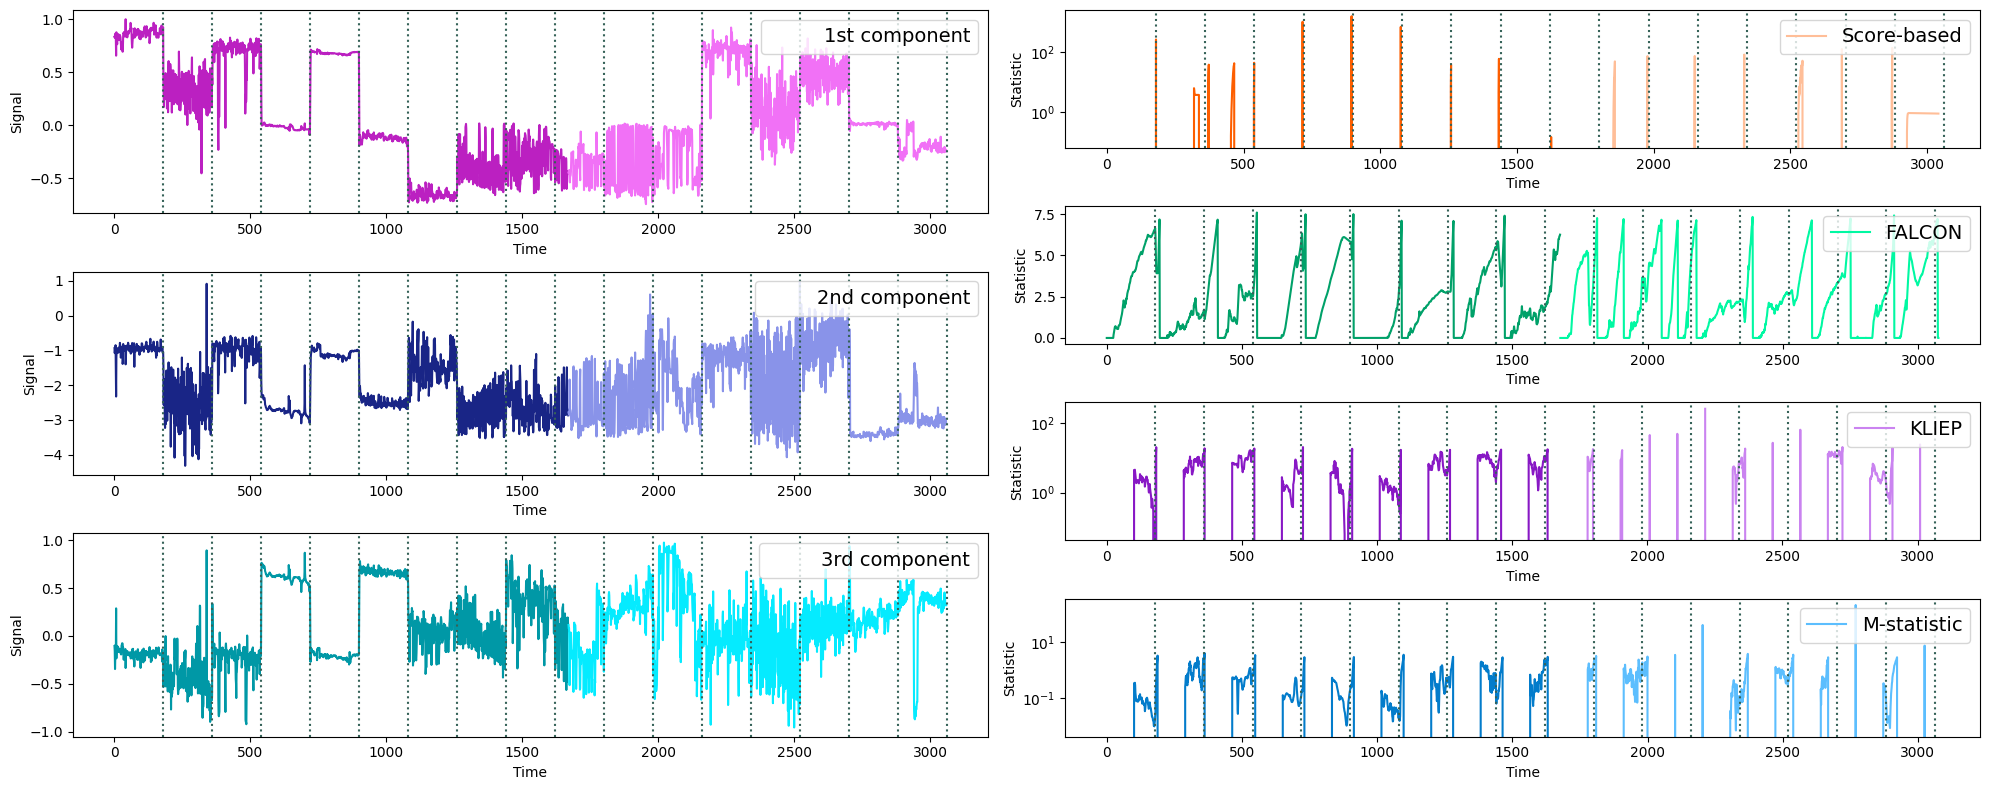

In [46]:
fig = plt.figure(figsize=(20, 8))

gs = GridSpec(12, 2, figure=fig)  

ax1 = fig.add_subplot(gs[0:4, 0])
ax1.plot(np.arange(val_end), data[:val_end, 0], c='#bb20c1')
ax1.plot(np.arange(test_start, test_end), data[test_start:test_end, 0], c='#f171f6')
ax1.plot(0, lw=0, label="1st component")
ax1.legend(loc='upper right', fontsize=14)
ax1.set_xlabel('Time')
ax1.set_ylabel('Signal')
for i in range(len(change_points)):
    ax1.axvline(change_points[i], c='#356258', ls=':')

ax2 = fig.add_subplot(gs[4:8, 0])
ax2.plot(np.arange(val_end), data[:val_end, 1], c='#192586')
ax2.plot(np.arange(test_start, test_end), data[test_start:test_end, 1], c='#8993e9')
ax2.plot(0, lw=0, label="2nd component")
ax2.legend(loc='upper right', fontsize=14)
ax2.set_xlabel('Time')
ax2.set_ylabel('Signal')
for i in range(len(change_points)):
    ax2.axvline(change_points[i], c='#356258', ls=':')


ax3 = fig.add_subplot(gs[8:12, 0])
ax3.plot(np.arange(val_end), data[:val_end, 2], c='#0098a6')
ax3.plot(np.arange(test_start, test_end), data[test_start:test_end, 2], c='#05ebff')
ax3.plot(0, lw=0, label="3rd component")
ax3.legend(loc='upper right', fontsize=14)
ax3.set_xlabel('Time')
ax3.set_ylabel('Signal')
for i in range(len(change_points)):
    ax3.axvline(change_points[i], c='#356258', ls=':')


ax4 = fig.add_subplot(gs[0:3, 1])
ax4.plot(np.arange(S_q_train.shape[0]), S_q_train, c='#fd5e00')
ax4.plot(np.arange(S_q_train.shape[0], S_q_train.shape[0] + S_q_test.shape[0]), S_q_test, c='#ffbe98', label="Score-based")
ax4.set_yscale('log')
ax4.legend(loc='upper right', fontsize=14)
ax4.set_xlabel('Time')
ax4.set_ylabel('Statistic')
for i in range(len(change_points)):
    ax4.axvline(change_points[i], c='#356258', ls=':')

ax5 = fig.add_subplot(gs[3:6, 1])
ax5.plot(np.arange(S_ftal_train.shape[0]), S_ftal_train, c='#00a169')
ax5.plot(np.arange(S_ftal_train.shape[0], S_ftal_train.shape[0] + S_ftal_test.shape[0]), S_ftal_test, c='#00f8a2', label="FALCON")
ax5.legend(loc='upper right', fontsize=14)
ax5.set_xlabel('Time')
ax5.set_ylabel('Statistic')
for i in range(len(change_points)):
    ax5.axvline(change_points[i], c='#356258', ls=':')

ax6 = fig.add_subplot(gs[6:9, 1])
ax6.plot(np.arange(S_kliep_train.shape[0]), S_kliep_train, c='#8818c5')
ax6.plot(np.arange(S_kliep_train.shape[0], S_kliep_train.shape[0] + S_kliep_test.shape[0]), S_kliep_test, c='#ca83f0', label="KLIEP")
ax6.set_yscale('log')
ax6.legend(loc='upper right', fontsize=14)
ax6.set_xlabel('Time')
ax6.set_ylabel('Statistic')
for i in range(len(change_points)):
    ax6.axvline(change_points[i], c='#356258', ls=':')

ax7 = fig.add_subplot(gs[9:12, 1])
ax7.plot(np.arange(S_mmd_train.shape[0]), S_mmd_train, c='#037ccb')
ax7.plot(np.arange(S_mmd_train.shape[0], S_mmd_train.shape[0] + S_mmd_test.shape[0]), S_mmd_test, c='#5cbefe', label="M-statistic")
ax7.set_yscale('log')
ax7.legend(loc='upper right', fontsize=14)
ax7.set_xlabel('Time')
ax7.set_ylabel('Statistic')
for i in range(len(change_points)):
    ax7.axvline(change_points[i], c='#356258', ls=':')



plt.tight_layout()
plt.savefig('wisdm.png')
plt.show()
